# install library

In [1]:
import os

if os.environ.get("KAGGLE_KERNEL_RUN_TYPE") is None:
    ON_KAGGLE = False
else:
    ON_KAGGLE = True
if not ON_KAGGLE:
    import shutil
    from requests import get

    from google.colab import drive, files
    # mount Google Drive
    drive.mount("/content/drive")
else:
    for dirname, _, filenames in os.walk('/kaggle/input'):
        for filename in filenames:
            print(os.path.join(dirname, filename))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
if not ON_KAGGLE: 
    !pip uninstall -y kaggle
    !pip install kaggle
    !mkdir /root/.kaggle
    !cp /content/drive/MyDrive/kaggla-za/kaggle.json /root/.kaggle
    !kaggle datasets download -d  kozodoi/timm-pytorch-image-models
    !mkdir -p ../input/timm-pytorch-image-models
    !unzip -n -qq timm-pytorch-image-models.zip -d ../input/timm-pytorch-image-models

    #一回のみ
    # !kaggle datasets download -d kalfirst/animal-imbalance-classification-round2
    # !mkdir -p ../content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/data/animal-imbalance-classification-round2
    # !unzip -n -qq animal-imbalance-classification-round2.zip -d ../content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/data/animal-imbalance-classification-round2

    !kaggle datasets download -d kalfirst/animal-imbalance-classification-round2
    !mkdir -p ../input/animal-imbalance-classification-round2
    !unzip -n -qq animal-imbalance-classification-round2.zip -d ../input/animal-imbalance-classification-round2

Found existing installation: kaggle 1.5.12
Uninstalling kaggle-1.5.12:
  Successfully uninstalled kaggle-1.5.12
  Using cached kaggle-1.5.12-py3-none-any.whl
mkdir: cannot create directory ‘/root/.kaggle’: File exists
timm-pytorch-image-models.zip: Skipping, found more recently modified local copy (use --force to force download)
animal-imbalance-classification-round2.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
import sys
sys.path.append("../input/timm-pytorch-image-models/pytorch-image-models-master")

if not ON_KAGGLE:
    !pip install albumentations==0.4.6
import albumentations as A
from albumentations.pytorch import ToTensorV2

import gc
import math
import os
import pickle
import random
import re
import time
import warnings
from contextlib import contextmanager

from pathlib import Path
from PIL import Image

#import albumentations as A
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import torch
import torch.nn as nn
import torch.nn.functional as F


#from albumentations.pytorch import ToTensorV2
from scipy.special import softmax
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from torch.optim import SGD, Adam, AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts, ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm

from sklearn.model_selection import StratifiedKFold

import timm
warnings.filterwarnings('ignore')

# Config


In [4]:
class Config:
    Version = "exp7" # model save時のversion
    MODEL_NAME = "resnet34" # モデル名
    #MODEL_NAME = "efficientnet_b0" # モデル名
    #MODEL_NAME = "efficientnet_b7" # モデル名
    #MODEL_NAME = "resnet50" # モデル名

    if ON_KAGGLE:
        # if MODEL_NAME == 'resnet34':
        #     model_name = '../input/pt-longformer-base' # https://www.kaggle.com/kishalmandal/pt-longformer-base
        # elif MODEL_NAME == 'roberta-base':
        #     model_name = '../input/roberta-base' #https://www.kaggle.com/abhishek/roberta-base
        # elif modeMODEL_NAMEl_savename == 'roberta-large':
        #     model_name = '../input/robertalarge' # https://www.kaggle.com/marshal02/robertalarge
        # elif MODEL_NAME == 'longformer-large':
        #     model_name = '../input/longformerlarge4096' # https://www.kaggle.com/hengzheng/longformerlarge4096 
        #base_dir = '/content/drive/MyDrive/petfinder'
        #data_dir = '../input/digit-recognizer/' # = DATA_PATH
        data_dir = '../input/animal-imbalance-classification-round2' # = DATA_PATH
        pre_data_dir = './preprocessed/'
        model_dir = '.'
        output_dir = '.'   
    else:
        # customize for my own Google Colab Environment
        # if model_savename == 'longformer':
        #     model_name = 'allenai/longformer-base-4096'
        # elif model_savename == 'roberta-base':
        #     model_name = 'roberta-base'
        base_dir = '/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance'
        data_dir = '../input/animal-imbalance-classification-round2'
        #pre_data_dir = os.path.join(base_dir, 'data/preprocessed')
        model_dir = os.path.join(base_dir, f'model/{Version}')
        output_dir = os.path.join(base_dir, f'output/{Version}')    

    is_debug = False
    if MODEL_NAME == 'resnet34':
        size = 224 # リサイズした後の画像のサイズ
        model_lr = 1e-5
    elif MODEL_NAME == 'roberta-base':
        size = 224 # リサイズした後の画像のサイズ
        model_lr = 1e-5
    elif MODEL_NAME == 'resnet50':
        size = 64 # リサイズした後の画像のサイズ
        model_lr = 1e-5
    seed = 42 # seed値
    #fold = 0
    N_FOLDS = 3
    num_workers = 4  #並列実行する数 was 0
    batch_size =  128 #バッチサイズ was 64 >100
    epochs = 50 #エポック数 10?
    #size = 224 # リサイズした後の画像のサイズ
    #model_lr = 1e-5 # 学習率
    T_max = 10 # 最大イテレーション数 was 10
    min_lr = 1e-5 # 学習率の最小値
    weight_decay = 1e-6 # 学習減衰値
    max_grad_norm = 1000 # 勾配の最大ノルム
    print_freq = 1000 # 学習結果を表示する頻度
    probability = 0.6
    class_num = 10 
    norms = (0.5, 0.5)
    device = "cuda" if torch.cuda.is_available() else "cpu" # CPU of GPU


In [5]:
if not ON_KAGGLE:
    if not os.path.exists(Config.model_dir):
        !mkdir $Config.model_dir
    if not os.path.exists(Config.output_dir):
        !mkdir $Config.output_dir

In [6]:
# from google.colab import drive
# drive.mount('/content/drive')

# Utils

In [7]:
def init_logger(log_file='train.log'):
    """Output Log."""
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger


def seed_torch(seed=Config.seed): # was seed=0
    """Fixed seed value."""
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False # added trueにすると再現性がなくなる


LOGGER = init_logger()
seed_torch(seed=Config.seed)

In [8]:
def asMinutes(s):
    """Convert Seconds to Minutes."""
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    """Accessing and Converting Time Data."""
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))

class AverageMeter(object):
    """Computes and stores the average and current value."""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

# Dataset

In [9]:
class TrainDataset(Dataset):
    """Dataset used for training."""
    def __init__(self, df, transform=None):
        self.df = df
        self.image_paths = df['image_id'].values
        self.labels = df['label'].values
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        #修正部分
        path = self.image_paths[idx]
        image = np.array(Image.open(path))
        # image = self.df.loc[idx, "pixel0": "pixel783"].values.astype(np.uint8).reshape(28, 28) # csv to image
        # image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB) # GRAY to RGB

        if self.transform:
            augmented = self.transform(image=image) # augmentation
            image = augmented['image']

        label = self.labels[idx] # 正解ラベル
        return image, label

In [10]:
class TestDataset(Dataset):
    """Dataset used for inference."""
    def __init__(self, df, transform=None):
        self.df = df
        self.image_paths = df['image_id'].values
        self.labels = df['label'].values
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        #修正部分
        path = self.image_paths[idx]
        image = np.array(Image.open(path))
        # image = self.df.loc[idx, "pixel0": "pixel783"].values.astype(np.uint8).reshape(28, 28)
        # image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']

        return image

# Data Augmentation

In [11]:
def get_transforms(*, data, size, norms):

    if data == 'train':
        return A.Compose([
            A.Resize(Config.size, Config.size), # リサイズ
            A.Rotate(limit=10, border_mode=cv2.BORDER_REPLICATE, p=0.5),
            A.Cutout(num_holes=8, max_h_size=2, max_w_size=2, fill_value=0, p=0.5),
            A.Cutout(num_holes=8, max_h_size=1, max_w_size=1, fill_value=1, p=0.5),
            A.VerticalFlip(p=0.5),
            A.HorizontalFlip(p=0.5),
            A.Normalize(mean=[norms[0], norms[0], norms[0]], std=[norms[1], norms[1], norms[1]], max_pixel_value=255.0, p=1.0), # 正規化
            ToTensorV2(), # Tensor型に変換
        ])

    elif data == 'valid':
        return A.Compose([
            A.Resize(Config.size, Config.size),
            A.Normalize(mean=[norms[0], norms[0], norms[0]], std=[norms[1], norms[1], norms[1]], max_pixel_value=255.0, p=1.0),
            ToTensorV2(),
        ])

# Model

In [12]:
# use timm model no pretrained
class BaseModel(nn.Module):
    def __init__(
        self, model_name=Config.MODEL_NAME, n_class=10, pretrained=False
    ):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained) # model load(pretrained=False: 事前学習なし)
        n_features = self.model.fc.in_features
        self.model.classifier = nn.Linear(n_features, n_class) # 出力層の次元をクラス数に変更

    def forward(self, x):
        output = self.model(x)
        return output

# train & valid function

In [13]:
def train_fn(train_loader, model, criterion, optimizer, epoch, scheduler):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()

    model.train() # 学習モード
    start = end = time.time()
    global_step = 0

    for step, (images, labels) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(Config.device) # 画像をcpuからgpuヘ
        labels = labels.to(Config.device) # 正解ラベルをcpuからgpuヘ
        batch_size = labels.size(0) 
        y_preds = model(images) # 予測ラベル
        loss = criterion(y_preds, labels) # lossの計算

        losses.update(loss.item(), batch_size) 
        loss.backward() # パラメータの勾配を計算
        
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), Config.max_grad_norm)
        optimizer.step() # モデル更新
        optimizer.zero_grad() # 勾配の初期化
        global_step += 1
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % Config.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(
                   epoch+1, step, len(train_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses,
                   remain=timeSince(start, float(step+1)/len(train_loader)),
                   grad_norm=grad_norm,
                   ))

        del y_preds, images, labels, batch_size
    del batch_time, data_time, model
    gc.collect()
    torch.cuda.empty_cache()
    
    return losses.avg

In [14]:
def valid_fn(valid_loader, model, criterion):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()

    # switch to evaluation mode
    model.eval()
    preds = []
    start = end = time.time()
    for step, (images, labels) in enumerate(valid_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(Config.device)
        labels = labels.to(Config.device)
        batch_size = labels.size(0)
        with torch.no_grad():
        #with torch.inference_mode(): Pytorch: ^1.9
            y_preds = model(images)
            loss = criterion(y_preds, labels)
            losses.update(loss.item(), batch_size)
            
            preds.append(y_preds.softmax(1).to("cpu").numpy().argmax(1))
            del loss
            batch_time.update(time.time() - end)
            end = time.time()
            if step % Config.print_freq == 0 or step == (len(valid_loader)-1):
                print('EVAL: [{0}/{1}] '
                    'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                    'Elapsed {remain:s} '
                    'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                    .format(
                    step, len(valid_loader), batch_time=batch_time,
                    data_time=data_time, loss=losses,
                    remain=timeSince(start, float(step+1)/len(valid_loader)),
                    ))
        del y_preds, images, labels, batch_size
    del batch_time, data_time, model
    gc.collect()
    torch.cuda.empty_cache()

    preds = np.concatenate(preds)

    return losses.avg, preds

# Dataの確認

In [15]:
#data_dir = "../input/digit-recognizer" # ディレクトリパス = data_dir
if ON_KAGGLE:
    train = pd.read_csv(Config.data_dir + "/train.csv") # csvの読み込み
    train['image_id'] = Config.data_dir + '/train_images/' + train['image_id']
else:
    train = pd.read_csv(f'{Config.data_dir}/train.csv')
    train['image_id'] = Config.data_dir + '/train_images/' + train['image_id']

train.head()

,image_id,label
0,../input/animal-imbalance-classification-round...,0
1,../input/animal-imbalance-classification-round...,0
2,../input/animal-imbalance-classification-round...,0
3,../input/animal-imbalance-classification-round...,0
4,../input/animal-imbalance-classification-round...,0


In [16]:
#train['image_id'][0]

In [17]:
import plotly.express as px

target = train.label.value_counts()
#class_num = len(target)

fig = px.pie(target,
             values='label',
             names=target.index,
             hole=.4, 
             width=500, height=500)
fig.update_traces(textinfo='value+label', pull=0.01)
fig.show()

In [18]:
fig = px.bar(target.sort_index().index, target.sort_index(), width=1000, height=400)
fig.show()

# 前処理

### ホールドアウト

In [19]:
# f0, f1 = train_test_split(train, test_size=0.2) # 学習用と評価用に分ける
# train["folds"] = -1
# train.loc[f0.index, "folds"] = 1
# train.loc[f1.index, "folds"] = 0
# train

## StratifiedKFold


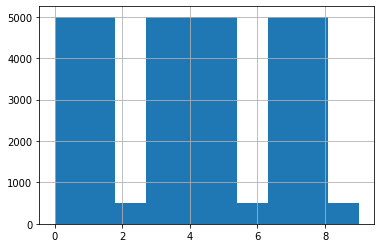

In [20]:
train['bins'] = pd.cut(train['label'], bins=Config.class_num, labels=False)
train['bins'].hist()

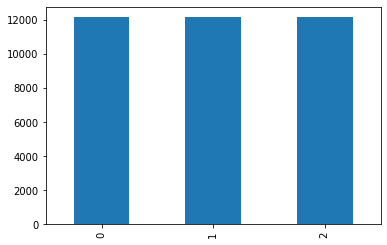

In [21]:
train['fold'] = -1

strat_kfold = StratifiedKFold(n_splits=Config.N_FOLDS, random_state=Config.seed, shuffle=True)
for i, (_, train_index) in enumerate(strat_kfold.split(train.index, train['bins'])):
    train.iloc[train_index, -1] = i
    
train['fold'] = train['fold'].astype('int')

train.fold.value_counts().plot.bar()

In [22]:
train[train['fold']==0].head()

,image_id,label,bins,fold
0,../input/animal-imbalance-classification-round...,0,0,0
3,../input/animal-imbalance-classification-round...,0,0,0
4,../input/animal-imbalance-classification-round...,0,0,0
5,../input/animal-imbalance-classification-round...,0,0,0
6,../input/animal-imbalance-classification-round...,0,0,0


In [23]:
train[train['fold']==0]['bins'].value_counts()

0    1667
1    1667
8    1667
4    1667
5    1667
3    1666
7    1666
2     167
9     167
6     166
Name: bins, dtype: int64

In [24]:
train[train['fold']==1]['bins'].value_counts()

0    1667
4    1667
8    1667
3    1667
7    1667
1    1666
5    1666
6     167
9     167
2     166
Name: bins, dtype: int64

#### 平均と標準偏差を計算

In [25]:
#修正部分
# images = train.loc[:, "pixel0": "pixel783"].values.astype(np.uint8).reshape(-1, 28, 28)
# norms = (np.mean(images[train.folds!=0] / 255), np.std(images[train.folds!=0] / 255)) # 平均と標準偏差を計算
# print("平均と標準偏差: ", norms)

#### 画像サイズの確認と数例を表示

In [26]:
# norms = (0.5, 0.5)
# train_dataset = TrainDataset(train,transform=get_transforms(data='train', size=Config.size, norms=Config.norms)) # 学習用のdatasetを作成
# train_loader = DataLoader(train_dataset, batch_size=Config.batch_size, shuffle=True, num_workers=Config.num_workers, pin_memory=True, drop_last=True)# 学習用のdatasetsのbatchを作成
# image_iter = iter(train_loader)
# images, labels = image_iter.next()

In [27]:
# print("height: ", images.shape[1])
# print("weight: ", images.shape[2])

# for n in range(3):
#     fig, axes = plt.subplots(1, 10, figsize=(20, 30))
#     [axes[i].imshow(images[idx]) for i, idx in enumerate(range(n*10, (n+1)*10))]

#     plt.show()

# 学習の際必要になる知識

## 評価指標(Accuracy), Confusion matrix
#### 詳細については、来週説明

## ハイパラメータの用語簡易説明など

> #### * 学習率 : 学習一回当たりの更新量のようなものです。 今回のデフォルトは1e-5です。
> #### * スケジューラー : epoch数に応じて、学習率を変化させるものです。 今回のデフォルトはCosineAnnealingLRです。
> #### * 損失関数: 正解ラベルと予測ラベルの誤差の大きさを計算する関数。 
> #### * 最適化関数: 効率よく損失を減らすための関数。 
> #### * timm : 画像のコンペでpytorchを使う場合にほぼ確実に使用するライブラリですので、見ておきましょう。[github](https://github.com/rwightman/pytorch-image-models)

# 軽めのモデル作成

### モデルの読み込み

In [28]:
model = BaseModel(Config.MODEL_NAME, Config.class_num)
model

BaseModel(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act2): ReLU(inplace=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, m

### 最適化関数

In [29]:
# Adam は勾配を移動平均と学習率の調整からなります (MomentumとRMSProp)
optimizer = Adam(model.parameters(), lr=Config.model_lr, weight_decay=Config.weight_decay, amsgrad=False)

### スケジューラ

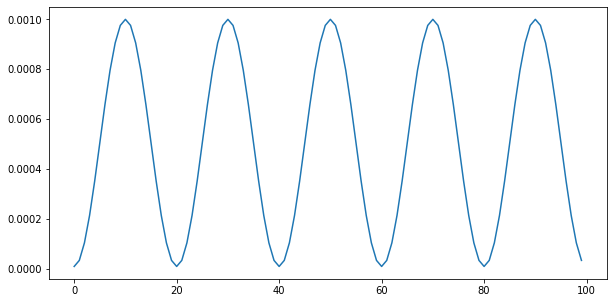

In [30]:
scheduler = CosineAnnealingLR(optimizer, T_max=Config.T_max, eta_min=0.001)

log_s = []
for epoch in range(0, 100):
    log_s.append(scheduler.get_last_lr()[0])
    scheduler.step()

plt.figure(figsize=(10, 5))
plt.plot(np.arange(100), log_s)
plt.show()

# 学習

In [31]:
def train_loop(train, fold, class_num=None, norms=(0.5, 0.5)):
    
    train_index = train[train['fold'] != fold].index # 学習用のindex
    valid_index = train[train['fold'] == fold].index # 評価用のindex

    train_dataset = TrainDataset(train.loc[train_index].reset_index(drop=True), 
                                 transform=get_transforms(data='train', size=Config.size, norms=norms)) # 学習用のdatasetを作成
    valid_dataset = TrainDataset(train.loc[valid_index].reset_index(drop=True), 
                                 transform=get_transforms(data='valid', size=Config.size, norms=norms)) # 評価用のdatasetを作成

    train_loader = DataLoader(train_dataset, batch_size=Config.batch_size, shuffle=True, 
                              num_workers=Config.num_workers, pin_memory=True, drop_last=True)# 学習用のdatasetsのbatchを作成
    valid_loader = DataLoader(valid_dataset, batch_size=Config.batch_size, shuffle=False, 
                              num_workers=Config.num_workers, pin_memory=True, drop_last=False) # 評価用のdatasetsのbatchを作成
    
    
    model = BaseModel(Config.MODEL_NAME, class_num).to(Config.device)

    optimizer = Adam(model.parameters(), lr=Config.model_lr, weight_decay=Config.weight_decay, amsgrad=False)
    scheduler = CosineAnnealingLR(optimizer, T_max=Config.T_max, eta_min=Config.min_lr, last_epoch=-1)

    criterion = nn.CrossEntropyLoss() # loss function

    best_score = 0.
    best_loss = np.inf
    
    for epoch in range(Config.epochs):
        start_time = time.time()
        avg_loss = train_fn(train_loader, model, criterion, optimizer, epoch, scheduler) # 学習
        avg_val_loss, predict = valid_fn(valid_loader, model, criterion) # 評価用の推論
        valid_labels = train.loc[valid_index, "label"].values # 予測ラベル
        
        scheduler.step() 
        score = accuracy_score(valid_labels, predict) # 適合率を計算
        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Accuracy: {score}')

        if score > best_score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            model_filename = f'{Config.model_dir}/{Config.MODEL_NAME}_fold{fold}_best_{Config.Version}.pth'
            torch.save(model.state_dict(), model_filename) # モデルの保存
            #torch.save(model.state_dict(), "./" + f'{Config.MODEL_NAME}_fold{fold}_best_{Config.Version}.pth') # モデルの保存
            print(f'{model_filename} saved')

            valid_folds_predict = predict
            
        del avg_loss, avg_val_loss, valid_labels, predict, score
        gc.collect()
        torch.cuda.empty_cache()

    return valid_folds_predict

In [32]:
#preds = train_loop(train, fold=Config.fold, class_num=Config.class_num, norms=Config.norms)
preds = [train_loop(train, fold=fold, class_num=Config.class_num, norms=Config.norms) for fold in range(Config.N_FOLDS) ]

Epoch: [1][0/190] Data 2.844 (2.844) Elapsed 0m 4s (remain 13m 38s) Loss: 6.8994(6.8994) 
Epoch: [1][189/190] Data 0.000 (0.032) Elapsed 1m 48s (remain 0m 0s) Loss: 5.9144(6.3933) 
EVAL: [0/96] Data 1.590 (1.590) Elapsed 0m 1s (remain 2m 47s) Loss: 5.9217(5.9217) 
EVAL: [95/96] Data 0.000 (0.105) Elapsed 0m 25s (remain 0m 0s) Loss: 6.3004(5.8665) 


Epoch 1 - avg_train_loss: 6.3933  avg_val_loss: 5.8665  time: 135s
Epoch 1 - Accuracy: 0.2671159694254952
Epoch 1 - Save Best Score: 0.2671 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp7/resnet34_fold0_best_exp7.pth saved
Epoch: [2][0/190] Data 1.826 (1.826) Elapsed 0m 2s (remain 7m 53s) Loss: 5.8554(5.8554) 
Epoch: [2][189/190] Data 0.000 (0.014) Elapsed 1m 40s (remain 0m 0s) Loss: 4.9243(5.3554) 
EVAL: [0/96] Data 1.568 (1.568) Elapsed 0m 1s (remain 2m 44s) Loss: 4.6375(4.6375) 
EVAL: [95/96] Data 0.000 (0.100) Elapsed 0m 24s (remain 0m 0s) Loss: 5.6681(4.8112) 


Epoch 2 - avg_train_loss: 5.3554  avg_val_loss: 4.8112  time: 126s
Epoch 2 - Accuracy: 0.29144407002547873
Epoch 2 - Save Best Score: 0.2914 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp7/resnet34_fold0_best_exp7.pth saved
Epoch: [3][0/190] Data 1.751 (1.751) Elapsed 0m 2s (remain 7m 26s) Loss: 4.9163(4.9163) 
Epoch: [3][189/190] Data 0.000 (0.014) Elapsed 1m 40s (remain 0m 0s) Loss: 3.8402(4.3434) 
EVAL: [0/96] Data 1.429 (1.429) Elapsed 0m 1s (remain 2m 30s) Loss: 3.5950(3.5950) 
EVAL: [95/96] Data 0.000 (0.100) Elapsed 0m 24s (remain 0m 0s) Loss: 5.0889(3.8507) 


Epoch 3 - avg_train_loss: 4.3434  avg_val_loss: 3.8507  time: 126s
Epoch 3 - Accuracy: 0.3064025643133065
Epoch 3 - Save Best Score: 0.3064 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp7/resnet34_fold0_best_exp7.pth saved
Epoch: [4][0/190] Data 2.000 (2.000) Elapsed 0m 2s (remain 8m 6s) Loss: 3.7984(3.7984) 
Epoch: [4][189/190] Data 0.000 (0.015) Elapsed 1m 40s (remain 0m 0s) Loss: 3.1708(3.4588) 
EVAL: [0/96] Data 1.242 (1.242) Elapsed 0m 1s (remain 2m 13s) Loss: 2.8255(2.8255) 
EVAL: [95/96] Data 0.000 (0.097) Elapsed 0m 24s (remain 0m 0s) Loss: 4.6397(3.0721) 


Epoch 4 - avg_train_loss: 3.4588  avg_val_loss: 3.0721  time: 126s
Epoch 4 - Accuracy: 0.32464863976329417
Epoch 4 - Save Best Score: 0.3246 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp7/resnet34_fold0_best_exp7.pth saved
Epoch: [5][0/190] Data 1.972 (1.972) Elapsed 0m 2s (remain 8m 14s) Loss: 3.1607(3.1607) 
Epoch: [5][189/190] Data 0.000 (0.015) Elapsed 1m 40s (remain 0m 0s) Loss: 2.4777(2.7853) 
EVAL: [0/96] Data 1.676 (1.676) Elapsed 0m 1s (remain 2m 54s) Loss: 2.3656(2.3656) 
EVAL: [95/96] Data 0.000 (0.101) Elapsed 0m 24s (remain 0m 0s) Loss: 4.3635(2.5232) 


Epoch 5 - avg_train_loss: 2.7853  avg_val_loss: 2.5232  time: 126s
Epoch 5 - Accuracy: 0.3499630147119257
Epoch 5 - Save Best Score: 0.3500 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp7/resnet34_fold0_best_exp7.pth saved
Epoch: [6][0/190] Data 1.847 (1.847) Elapsed 0m 2s (remain 7m 54s) Loss: 2.4253(2.4253) 
Epoch: [6][189/190] Data 0.000 (0.014) Elapsed 1m 40s (remain 0m 0s) Loss: 2.0236(2.3340) 
EVAL: [0/96] Data 1.294 (1.294) Elapsed 0m 1s (remain 2m 20s) Loss: 2.0122(2.0122) 
EVAL: [95/96] Data 0.000 (0.102) Elapsed 0m 24s (remain 0m 0s) Loss: 4.2577(2.1730) 


Epoch 6 - avg_train_loss: 2.3340  avg_val_loss: 2.1730  time: 126s
Epoch 6 - Accuracy: 0.37478425248623326
Epoch 6 - Save Best Score: 0.3748 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp7/resnet34_fold0_best_exp7.pth saved
Epoch: [7][0/190] Data 1.699 (1.699) Elapsed 0m 2s (remain 7m 23s) Loss: 2.0838(2.0838) 
Epoch: [7][189/190] Data 0.000 (0.013) Elapsed 1m 40s (remain 0m 0s) Loss: 1.9764(2.0584) 
EVAL: [0/96] Data 1.263 (1.263) Elapsed 0m 1s (remain 2m 15s) Loss: 1.8533(1.8533) 
EVAL: [95/96] Data 0.000 (0.101) Elapsed 0m 24s (remain 0m 0s) Loss: 4.2413(1.9565) 


Epoch 7 - avg_train_loss: 2.0584  avg_val_loss: 1.9565  time: 126s
Epoch 7 - Accuracy: 0.41045450809566864
Epoch 7 - Save Best Score: 0.4105 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp7/resnet34_fold0_best_exp7.pth saved
Epoch: [8][0/190] Data 1.754 (1.754) Elapsed 0m 2s (remain 7m 37s) Loss: 2.0349(2.0349) 
Epoch: [8][189/190] Data 0.000 (0.014) Elapsed 1m 40s (remain 0m 0s) Loss: 1.8518(1.8810) 
EVAL: [0/96] Data 1.528 (1.528) Elapsed 0m 1s (remain 2m 40s) Loss: 1.7173(1.7173) 
EVAL: [95/96] Data 0.000 (0.103) Elapsed 0m 25s (remain 0m 0s) Loss: 4.2464(1.8181) 


Epoch 8 - avg_train_loss: 1.8810  avg_val_loss: 1.8181  time: 126s
Epoch 8 - Accuracy: 0.4319059751787622
Epoch 8 - Save Best Score: 0.4319 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp7/resnet34_fold0_best_exp7.pth saved
Epoch: [9][0/190] Data 1.722 (1.722) Elapsed 0m 2s (remain 7m 23s) Loss: 1.8160(1.8160) 
Epoch: [9][189/190] Data 0.000 (0.014) Elapsed 1m 40s (remain 0m 0s) Loss: 1.7291(1.7634) 
EVAL: [0/96] Data 0.886 (0.886) Elapsed 0m 1s (remain 1m 39s) Loss: 1.6801(1.6801) 
EVAL: [95/96] Data 0.000 (0.098) Elapsed 0m 24s (remain 0m 0s) Loss: 4.2686(1.7170) 


Epoch 9 - avg_train_loss: 1.7634  avg_val_loss: 1.7170  time: 126s
Epoch 9 - Accuracy: 0.4535218213199638
Epoch 9 - Save Best Score: 0.4535 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp7/resnet34_fold0_best_exp7.pth saved
Epoch: [10][0/190] Data 1.771 (1.771) Elapsed 0m 2s (remain 7m 43s) Loss: 1.6720(1.6720) 
Epoch: [10][189/190] Data 0.000 (0.013) Elapsed 1m 40s (remain 0m 0s) Loss: 1.7371(1.6776) 
EVAL: [0/96] Data 1.174 (1.174) Elapsed 0m 1s (remain 2m 6s) Loss: 1.5422(1.5422) 
EVAL: [95/96] Data 0.000 (0.094) Elapsed 0m 24s (remain 0m 0s) Loss: 4.2407(1.6463) 


Epoch 10 - avg_train_loss: 1.6776  avg_val_loss: 1.6463  time: 126s
Epoch 10 - Accuracy: 0.4659324402071176
Epoch 10 - Save Best Score: 0.4659 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp7/resnet34_fold0_best_exp7.pth saved
Epoch: [11][0/190] Data 1.759 (1.759) Elapsed 0m 2s (remain 7m 41s) Loss: 1.5866(1.5866) 
Epoch: [11][189/190] Data 0.000 (0.014) Elapsed 1m 40s (remain 0m 0s) Loss: 1.6625(1.6112) 
EVAL: [0/96] Data 1.636 (1.636) Elapsed 0m 1s (remain 2m 50s) Loss: 1.5110(1.5110) 
EVAL: [95/96] Data 0.000 (0.100) Elapsed 0m 24s (remain 0m 0s) Loss: 4.2668(1.5825) 


Epoch 11 - avg_train_loss: 1.6112  avg_val_loss: 1.5825  time: 126s
Epoch 11 - Accuracy: 0.47694583710035343
Epoch 11 - Save Best Score: 0.4769 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp7/resnet34_fold0_best_exp7.pth saved
Epoch: [12][0/190] Data 1.912 (1.912) Elapsed 0m 2s (remain 7m 51s) Loss: 1.4841(1.4841) 
Epoch: [12][189/190] Data 0.000 (0.014) Elapsed 1m 40s (remain 0m 0s) Loss: 1.6493(1.5555) 
EVAL: [0/96] Data 1.284 (1.284) Elapsed 0m 1s (remain 2m 18s) Loss: 1.4593(1.4593) 
EVAL: [95/96] Data 0.000 (0.101) Elapsed 0m 24s (remain 0m 0s) Loss: 4.1813(1.5298) 


Epoch 12 - avg_train_loss: 1.5555  avg_val_loss: 1.5298  time: 126s
Epoch 12 - Accuracy: 0.4925618476206131
Epoch 12 - Save Best Score: 0.4926 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp7/resnet34_fold0_best_exp7.pth saved
Epoch: [13][0/190] Data 1.778 (1.778) Elapsed 0m 2s (remain 7m 46s) Loss: 1.5025(1.5025) 
Epoch: [13][189/190] Data 0.000 (0.014) Elapsed 1m 40s (remain 0m 0s) Loss: 1.6326(1.5119) 
EVAL: [0/96] Data 1.187 (1.187) Elapsed 0m 1s (remain 2m 12s) Loss: 1.4362(1.4362) 
EVAL: [95/96] Data 0.000 (0.099) Elapsed 0m 25s (remain 0m 0s) Loss: 4.2267(1.4888) 


Epoch 13 - avg_train_loss: 1.5119  avg_val_loss: 1.4888  time: 126s
Epoch 13 - Accuracy: 0.49626037642804305
Epoch 13 - Save Best Score: 0.4963 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp7/resnet34_fold0_best_exp7.pth saved
Epoch: [14][0/190] Data 2.068 (2.068) Elapsed 0m 2s (remain 8m 25s) Loss: 1.5088(1.5088) 
Epoch: [14][189/190] Data 0.000 (0.015) Elapsed 1m 40s (remain 0m 0s) Loss: 1.4199(1.4676) 
EVAL: [0/96] Data 1.341 (1.341) Elapsed 0m 1s (remain 2m 23s) Loss: 1.4411(1.4411) 
EVAL: [95/96] Data 0.000 (0.099) Elapsed 0m 24s (remain 0m 0s) Loss: 4.2388(1.4471) 


Epoch 14 - avg_train_loss: 1.4676  avg_val_loss: 1.4471  time: 126s
Epoch 14 - Accuracy: 0.5086709953151969
Epoch 14 - Save Best Score: 0.5087 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp7/resnet34_fold0_best_exp7.pth saved
Epoch: [15][0/190] Data 1.973 (1.973) Elapsed 0m 2s (remain 8m 5s) Loss: 1.4231(1.4231) 
Epoch: [15][189/190] Data 0.000 (0.015) Elapsed 1m 40s (remain 0m 0s) Loss: 1.3792(1.4372) 
EVAL: [0/96] Data 1.261 (1.261) Elapsed 0m 1s (remain 2m 15s) Loss: 1.4143(1.4143) 
EVAL: [95/96] Data 0.000 (0.097) Elapsed 0m 24s (remain 0m 0s) Loss: 4.1288(1.4227) 


Epoch 15 - avg_train_loss: 1.4372  avg_val_loss: 1.4227  time: 126s
Epoch 15 - Accuracy: 0.5149995890523548
Epoch 15 - Save Best Score: 0.5150 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp7/resnet34_fold0_best_exp7.pth saved
Epoch: [16][0/190] Data 1.930 (1.930) Elapsed 0m 2s (remain 8m 5s) Loss: 1.4023(1.4023) 
Epoch: [16][189/190] Data 0.000 (0.014) Elapsed 1m 40s (remain 0m 0s) Loss: 1.3517(1.4054) 
EVAL: [0/96] Data 1.398 (1.398) Elapsed 0m 1s (remain 2m 30s) Loss: 1.3140(1.3140) 
EVAL: [95/96] Data 0.000 (0.103) Elapsed 0m 25s (remain 0m 0s) Loss: 4.1342(1.3967) 


Epoch 16 - avg_train_loss: 1.4054  avg_val_loss: 1.3967  time: 126s
Epoch 16 - Accuracy: 0.5225610257253226
Epoch 16 - Save Best Score: 0.5226 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp7/resnet34_fold0_best_exp7.pth saved
Epoch: [17][0/190] Data 2.039 (2.039) Elapsed 0m 2s (remain 8m 16s) Loss: 1.5112(1.5112) 
Epoch: [17][189/190] Data 0.000 (0.015) Elapsed 1m 40s (remain 0m 0s) Loss: 1.4278(1.3765) 
EVAL: [0/96] Data 1.359 (1.359) Elapsed 0m 1s (remain 2m 26s) Loss: 1.3622(1.3622) 
EVAL: [95/96] Data 0.000 (0.104) Elapsed 0m 25s (remain 0m 0s) Loss: 4.1842(1.3656) 


Epoch 17 - avg_train_loss: 1.3765  avg_val_loss: 1.3656  time: 126s
Epoch 17 - Accuracy: 0.5321772006246405
Epoch 17 - Save Best Score: 0.5322 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp7/resnet34_fold0_best_exp7.pth saved
Epoch: [18][0/190] Data 1.785 (1.785) Elapsed 0m 2s (remain 7m 46s) Loss: 1.1818(1.1818) 
Epoch: [18][189/190] Data 0.000 (0.013) Elapsed 1m 40s (remain 0m 0s) Loss: 1.2935(1.3530) 
EVAL: [0/96] Data 1.551 (1.551) Elapsed 0m 1s (remain 2m 42s) Loss: 1.2314(1.2314) 
EVAL: [95/96] Data 0.000 (0.102) Elapsed 0m 25s (remain 0m 0s) Loss: 4.1298(1.3437) 


Epoch 18 - avg_train_loss: 1.3530  avg_val_loss: 1.3437  time: 126s
Epoch 18 - Accuracy: 0.5353825922577463
Epoch 18 - Save Best Score: 0.5354 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp7/resnet34_fold0_best_exp7.pth saved
Epoch: [19][0/190] Data 2.171 (2.171) Elapsed 0m 2s (remain 8m 32s) Loss: 1.4446(1.4446) 
Epoch: [19][189/190] Data 0.000 (0.016) Elapsed 1m 40s (remain 0m 0s) Loss: 1.2980(1.3303) 
EVAL: [0/96] Data 1.318 (1.318) Elapsed 0m 1s (remain 2m 23s) Loss: 1.3188(1.3188) 
EVAL: [95/96] Data 0.000 (0.101) Elapsed 0m 25s (remain 0m 0s) Loss: 4.1490(1.3225) 


Epoch 19 - avg_train_loss: 1.3303  avg_val_loss: 1.3225  time: 127s
Epoch 19 - Accuracy: 0.5420399441111202
Epoch 19 - Save Best Score: 0.5420 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp7/resnet34_fold0_best_exp7.pth saved
Epoch: [20][0/190] Data 1.746 (1.746) Elapsed 0m 2s (remain 7m 25s) Loss: 1.3503(1.3503) 
Epoch: [20][189/190] Data 0.000 (0.014) Elapsed 1m 40s (remain 0m 0s) Loss: 1.3244(1.3109) 
EVAL: [0/96] Data 1.280 (1.280) Elapsed 0m 1s (remain 2m 17s) Loss: 1.3606(1.3606) 
EVAL: [95/96] Data 0.000 (0.107) Elapsed 0m 25s (remain 0m 0s) Loss: 4.3319(1.3076) 


Epoch 20 - avg_train_loss: 1.3109  avg_val_loss: 1.3076  time: 127s
Epoch 20 - Accuracy: 0.5462316100928741
Epoch 20 - Save Best Score: 0.5462 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp7/resnet34_fold0_best_exp7.pth saved
Epoch: [21][0/190] Data 1.974 (1.974) Elapsed 0m 2s (remain 8m 5s) Loss: 1.2505(1.2505) 
Epoch: [21][189/190] Data 0.000 (0.015) Elapsed 1m 40s (remain 0m 0s) Loss: 1.2739(1.2921) 
EVAL: [0/96] Data 1.426 (1.426) Elapsed 0m 1s (remain 2m 34s) Loss: 1.3424(1.3424) 
EVAL: [95/96] Data 0.000 (0.098) Elapsed 0m 24s (remain 0m 0s) Loss: 4.1862(1.2971) 


Epoch 21 - avg_train_loss: 1.2921  avg_val_loss: 1.2971  time: 126s
Epoch 21 - Accuracy: 0.5461494205638202


Epoch: [22][0/190] Data 1.894 (1.894) Elapsed 0m 2s (remain 7m 59s) Loss: 1.3116(1.3116) 
Epoch: [22][189/190] Data 0.000 (0.015) Elapsed 1m 40s (remain 0m 0s) Loss: 1.2855(1.2759) 
EVAL: [0/96] Data 1.245 (1.245) Elapsed 0m 1s (remain 2m 15s) Loss: 1.2491(1.2491) 
EVAL: [95/96] Data 0.000 (0.101) Elapsed 0m 24s (remain 0m 0s) Loss: 4.2249(1.2712) 


Epoch 22 - avg_train_loss: 1.2759  avg_val_loss: 1.2712  time: 126s
Epoch 22 - Accuracy: 0.553710857236788
Epoch 22 - Save Best Score: 0.5537 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp7/resnet34_fold0_best_exp7.pth saved
Epoch: [23][0/190] Data 1.786 (1.786) Elapsed 0m 2s (remain 7m 26s) Loss: 1.1773(1.1773) 
Epoch: [23][189/190] Data 0.000 (0.014) Elapsed 1m 40s (remain 0m 0s) Loss: 1.2302(1.2583) 
EVAL: [0/96] Data 1.259 (1.259) Elapsed 0m 1s (remain 2m 15s) Loss: 1.2402(1.2402) 
EVAL: [95/96] Data 0.000 (0.107) Elapsed 0m 25s (remain 0m 0s) Loss: 4.2247(1.2582) 


Epoch 23 - avg_train_loss: 1.2583  avg_val_loss: 1.2582  time: 126s
Epoch 23 - Accuracy: 0.555108079230706
Epoch 23 - Save Best Score: 0.5551 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp7/resnet34_fold0_best_exp7.pth saved
Epoch: [24][0/190] Data 1.868 (1.868) Elapsed 0m 2s (remain 7m 59s) Loss: 1.2710(1.2710) 
Epoch: [24][189/190] Data 0.000 (0.015) Elapsed 1m 40s (remain 0m 0s) Loss: 1.2465(1.2464) 
EVAL: [0/96] Data 1.401 (1.401) Elapsed 0m 1s (remain 2m 30s) Loss: 1.2154(1.2154) 
EVAL: [95/96] Data 0.000 (0.106) Elapsed 0m 25s (remain 0m 0s) Loss: 4.2074(1.2370) 


Epoch 24 - avg_train_loss: 1.2464  avg_val_loss: 1.2370  time: 126s
Epoch 24 - Accuracy: 0.5654639598915098
Epoch 24 - Save Best Score: 0.5655 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp7/resnet34_fold0_best_exp7.pth saved
Epoch: [25][0/190] Data 1.803 (1.803) Elapsed 0m 2s (remain 7m 50s) Loss: 1.2371(1.2371) 
Epoch: [25][189/190] Data 0.000 (0.014) Elapsed 1m 40s (remain 0m 0s) Loss: 1.2909(1.2314) 
EVAL: [0/96] Data 1.393 (1.393) Elapsed 0m 1s (remain 2m 29s) Loss: 1.1608(1.1608) 
EVAL: [95/96] Data 0.000 (0.098) Elapsed 0m 24s (remain 0m 0s) Loss: 4.1396(1.2248) 


Epoch 25 - avg_train_loss: 1.2314  avg_val_loss: 1.2248  time: 125s
Epoch 25 - Accuracy: 0.5701487630475878
Epoch 25 - Save Best Score: 0.5701 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp7/resnet34_fold0_best_exp7.pth saved
Epoch: [26][0/190] Data 1.818 (1.818) Elapsed 0m 2s (remain 7m 48s) Loss: 1.1775(1.1775) 
Epoch: [26][189/190] Data 0.000 (0.014) Elapsed 1m 40s (remain 0m 0s) Loss: 1.2212(1.2176) 
EVAL: [0/96] Data 1.522 (1.522) Elapsed 0m 1s (remain 2m 40s) Loss: 1.2087(1.2087) 
EVAL: [95/96] Data 0.000 (0.097) Elapsed 0m 24s (remain 0m 0s) Loss: 4.2029(1.2169) 


Epoch 26 - avg_train_loss: 1.2176  avg_val_loss: 1.2169  time: 126s
Epoch 26 - Accuracy: 0.5732719651516397
Epoch 26 - Save Best Score: 0.5733 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp7/resnet34_fold0_best_exp7.pth saved
Epoch: [27][0/190] Data 1.624 (1.624) Elapsed 0m 2s (remain 7m 0s) Loss: 1.0819(1.0819) 
Epoch: [27][189/190] Data 0.000 (0.013) Elapsed 1m 39s (remain 0m 0s) Loss: 1.2407(1.2069) 
EVAL: [0/96] Data 1.319 (1.319) Elapsed 0m 1s (remain 2m 22s) Loss: 1.1999(1.1999) 
EVAL: [95/96] Data 0.000 (0.102) Elapsed 0m 25s (remain 0m 0s) Loss: 4.2460(1.2094) 


Epoch 27 - avg_train_loss: 1.2069  avg_val_loss: 1.2094  time: 126s
Epoch 27 - Accuracy: 0.5754910824360976
Epoch 27 - Save Best Score: 0.5755 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp7/resnet34_fold0_best_exp7.pth saved
Epoch: [28][0/190] Data 2.102 (2.102) Elapsed 0m 2s (remain 8m 28s) Loss: 1.2583(1.2583) 
Epoch: [28][189/190] Data 0.000 (0.015) Elapsed 1m 40s (remain 0m 0s) Loss: 1.0885(1.1929) 
EVAL: [0/96] Data 1.299 (1.299) Elapsed 0m 1s (remain 2m 19s) Loss: 1.2126(1.2126) 
EVAL: [95/96] Data 0.000 (0.103) Elapsed 0m 25s (remain 0m 0s) Loss: 4.1964(1.1954) 


Epoch 28 - avg_train_loss: 1.1929  avg_val_loss: 1.1954  time: 126s
Epoch 28 - Accuracy: 0.5788608531273116
Epoch 28 - Save Best Score: 0.5789 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp7/resnet34_fold0_best_exp7.pth saved
Epoch: [29][0/190] Data 1.837 (1.837) Elapsed 0m 2s (remain 7m 32s) Loss: 1.2042(1.2042) 
Epoch: [29][189/190] Data 0.000 (0.014) Elapsed 1m 40s (remain 0m 0s) Loss: 1.3348(1.1847) 
EVAL: [0/96] Data 1.433 (1.433) Elapsed 0m 1s (remain 2m 32s) Loss: 1.1947(1.1947) 
EVAL: [95/96] Data 0.000 (0.110) Elapsed 0m 25s (remain 0m 0s) Loss: 4.2937(1.1885) 


Epoch 29 - avg_train_loss: 1.1847  avg_val_loss: 1.1885  time: 127s
Epoch 29 - Accuracy: 0.5837100353414975
Epoch 29 - Save Best Score: 0.5837 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp7/resnet34_fold0_best_exp7.pth saved
Epoch: [30][0/190] Data 2.086 (2.086) Elapsed 0m 2s (remain 8m 17s) Loss: 1.0464(1.0464) 
Epoch: [30][189/190] Data 0.000 (0.016) Elapsed 1m 40s (remain 0m 0s) Loss: 1.1953(1.1723) 
EVAL: [0/96] Data 1.203 (1.203) Elapsed 0m 1s (remain 2m 12s) Loss: 1.1656(1.1656) 
EVAL: [95/96] Data 0.000 (0.104) Elapsed 0m 25s (remain 0m 0s) Loss: 4.1615(1.1806) 


Epoch 30 - avg_train_loss: 1.1723  avg_val_loss: 1.1806  time: 126s
Epoch 30 - Accuracy: 0.5867510479164955
Epoch 30 - Save Best Score: 0.5868 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp7/resnet34_fold0_best_exp7.pth saved
Epoch: [31][0/190] Data 2.191 (2.191) Elapsed 0m 2s (remain 8m 41s) Loss: 1.1409(1.1409) 
Epoch: [31][189/190] Data 0.000 (0.016) Elapsed 1m 40s (remain 0m 0s) Loss: 1.1692(1.1629) 
EVAL: [0/96] Data 1.280 (1.280) Elapsed 0m 1s (remain 2m 17s) Loss: 1.0890(1.0890) 
EVAL: [95/96] Data 0.000 (0.102) Elapsed 0m 25s (remain 0m 0s) Loss: 4.2724(1.1709) 


Epoch 31 - avg_train_loss: 1.1629  avg_val_loss: 1.1709  time: 127s
Epoch 31 - Accuracy: 0.5834634667543355


Epoch: [32][0/190] Data 1.895 (1.895) Elapsed 0m 2s (remain 8m 1s) Loss: 1.1826(1.1826) 
Epoch: [32][189/190] Data 0.000 (0.015) Elapsed 1m 40s (remain 0m 0s) Loss: 1.2578(1.1526) 
EVAL: [0/96] Data 1.419 (1.419) Elapsed 0m 1s (remain 2m 30s) Loss: 1.0175(1.0175) 
EVAL: [95/96] Data 0.000 (0.105) Elapsed 0m 25s (remain 0m 0s) Loss: 4.2593(1.1558) 


Epoch 32 - avg_train_loss: 1.1526  avg_val_loss: 1.1558  time: 126s
Epoch 32 - Accuracy: 0.5899564395496014
Epoch 32 - Save Best Score: 0.5900 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp7/resnet34_fold0_best_exp7.pth saved
Epoch: [33][0/190] Data 1.817 (1.817) Elapsed 0m 2s (remain 7m 43s) Loss: 1.1532(1.1532) 
Epoch: [33][189/190] Data 0.000 (0.014) Elapsed 1m 40s (remain 0m 0s) Loss: 1.0004(1.1417) 
EVAL: [0/96] Data 1.404 (1.404) Elapsed 0m 1s (remain 2m 30s) Loss: 1.0678(1.0678) 
EVAL: [95/96] Data 0.000 (0.103) Elapsed 0m 25s (remain 0m 0s) Loss: 4.1468(1.1468) 


Epoch 33 - avg_train_loss: 1.1417  avg_val_loss: 1.1468  time: 126s
Epoch 33 - Accuracy: 0.5951343798800033
Epoch 33 - Save Best Score: 0.5951 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp7/resnet34_fold0_best_exp7.pth saved
Epoch: [34][0/190] Data 1.834 (1.834) Elapsed 0m 2s (remain 7m 56s) Loss: 1.1258(1.1258) 
Epoch: [34][189/190] Data 0.000 (0.014) Elapsed 1m 40s (remain 0m 0s) Loss: 1.1243(1.1312) 
EVAL: [0/96] Data 1.292 (1.292) Elapsed 0m 1s (remain 2m 19s) Loss: 1.0724(1.0724) 
EVAL: [95/96] Data 0.000 (0.096) Elapsed 0m 24s (remain 0m 0s) Loss: 4.0881(1.1347) 


Epoch 34 - avg_train_loss: 1.1312  avg_val_loss: 1.1347  time: 126s
Epoch 34 - Accuracy: 0.6017095422043232
Epoch 34 - Save Best Score: 0.6017 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp7/resnet34_fold0_best_exp7.pth saved
Epoch: [35][0/190] Data 1.966 (1.966) Elapsed 0m 2s (remain 8m 5s) Loss: 1.2346(1.2346) 
Epoch: [35][189/190] Data 0.000 (0.014) Elapsed 1m 40s (remain 0m 0s) Loss: 1.0473(1.1253) 
EVAL: [0/96] Data 1.593 (1.593) Elapsed 0m 1s (remain 2m 47s) Loss: 1.1453(1.1453) 
EVAL: [95/96] Data 0.000 (0.095) Elapsed 0m 24s (remain 0m 0s) Loss: 4.2704(1.1344) 


Epoch 35 - avg_train_loss: 1.1253  avg_val_loss: 1.1344  time: 125s
Epoch 35 - Accuracy: 0.5980932029259473


Epoch: [36][0/190] Data 1.894 (1.894) Elapsed 0m 2s (remain 8m 1s) Loss: 1.1149(1.1149) 
Epoch: [36][189/190] Data 0.000 (0.014) Elapsed 1m 40s (remain 0m 0s) Loss: 1.0882(1.1134) 
EVAL: [0/96] Data 1.234 (1.234) Elapsed 0m 1s (remain 2m 13s) Loss: 1.0272(1.0272) 
EVAL: [95/96] Data 0.000 (0.095) Elapsed 0m 24s (remain 0m 0s) Loss: 4.3036(1.1230) 


Epoch 36 - avg_train_loss: 1.1134  avg_val_loss: 1.1230  time: 125s
Epoch 36 - Accuracy: 0.6032711432563491
Epoch 36 - Save Best Score: 0.6033 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp7/resnet34_fold0_best_exp7.pth saved
Epoch: [37][0/190] Data 1.728 (1.728) Elapsed 0m 2s (remain 7m 33s) Loss: 1.0452(1.0452) 
Epoch: [37][189/190] Data 0.000 (0.013) Elapsed 1m 40s (remain 0m 0s) Loss: 1.1645(1.1065) 
EVAL: [0/96] Data 1.242 (1.242) Elapsed 0m 1s (remain 2m 14s) Loss: 1.1150(1.1150) 
EVAL: [95/96] Data 0.000 (0.092) Elapsed 0m 24s (remain 0m 0s) Loss: 4.1407(1.1417) 


Epoch 37 - avg_train_loss: 1.1065  avg_val_loss: 1.1417  time: 125s
Epoch 37 - Accuracy: 0.5931618311827074


Epoch: [38][0/190] Data 1.609 (1.609) Elapsed 0m 2s (remain 6m 52s) Loss: 0.8992(0.8992) 
Epoch: [38][189/190] Data 0.000 (0.013) Elapsed 1m 39s (remain 0m 0s) Loss: 1.0471(1.1009) 
EVAL: [0/96] Data 1.174 (1.174) Elapsed 0m 1s (remain 2m 10s) Loss: 1.0027(1.0027) 
EVAL: [95/96] Data 0.000 (0.094) Elapsed 0m 24s (remain 0m 0s) Loss: 4.0692(1.1064) 


Epoch 38 - avg_train_loss: 1.1009  avg_val_loss: 1.1064  time: 125s
Epoch 38 - Accuracy: 0.608860031232021
Epoch 38 - Save Best Score: 0.6089 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp7/resnet34_fold0_best_exp7.pth saved
Epoch: [39][0/190] Data 1.753 (1.753) Elapsed 0m 2s (remain 7m 37s) Loss: 1.0591(1.0591) 
Epoch: [39][189/190] Data 0.000 (0.014) Elapsed 1m 40s (remain 0m 0s) Loss: 1.2476(1.0882) 
EVAL: [0/96] Data 1.247 (1.247) Elapsed 0m 1s (remain 2m 14s) Loss: 1.0152(1.0152) 
EVAL: [95/96] Data 0.000 (0.094) Elapsed 0m 24s (remain 0m 0s) Loss: 4.0986(1.1044) 


Epoch 39 - avg_train_loss: 1.0882  avg_val_loss: 1.1044  time: 125s
Epoch 39 - Accuracy: 0.610996958987425
Epoch 39 - Save Best Score: 0.6110 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp7/resnet34_fold0_best_exp7.pth saved
Epoch: [40][0/190] Data 1.731 (1.731) Elapsed 0m 2s (remain 7m 25s) Loss: 1.1254(1.1254) 
Epoch: [40][189/190] Data 0.000 (0.013) Elapsed 1m 39s (remain 0m 0s) Loss: 1.0806(1.0799) 
EVAL: [0/96] Data 1.293 (1.293) Elapsed 0m 1s (remain 2m 18s) Loss: 0.9890(0.9890) 
EVAL: [95/96] Data 0.000 (0.097) Elapsed 0m 24s (remain 0m 0s) Loss: 4.2710(1.0999) 


Epoch 40 - avg_train_loss: 1.0799  avg_val_loss: 1.0999  time: 125s
Epoch 40 - Accuracy: 0.610832579929317


Epoch: [41][0/190] Data 1.874 (1.874) Elapsed 0m 2s (remain 7m 49s) Loss: 1.0149(1.0149) 
Epoch: [41][189/190] Data 0.000 (0.014) Elapsed 1m 39s (remain 0m 0s) Loss: 0.9660(1.0771) 
EVAL: [0/96] Data 1.304 (1.304) Elapsed 0m 1s (remain 2m 20s) Loss: 1.0905(1.0905) 
EVAL: [95/96] Data 0.000 (0.094) Elapsed 0m 24s (remain 0m 0s) Loss: 4.2399(1.0939) 


Epoch 41 - avg_train_loss: 1.0771  avg_val_loss: 1.0939  time: 125s
Epoch 41 - Accuracy: 0.6135448343880989
Epoch 41 - Save Best Score: 0.6135 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp7/resnet34_fold0_best_exp7.pth saved
Epoch: [42][0/190] Data 2.120 (2.120) Elapsed 0m 2s (remain 8m 23s) Loss: 1.1392(1.1392) 
Epoch: [42][189/190] Data 0.000 (0.016) Elapsed 1m 40s (remain 0m 0s) Loss: 1.0338(1.0643) 
EVAL: [0/96] Data 1.495 (1.495) Elapsed 0m 1s (remain 2m 38s) Loss: 1.0079(1.0079) 
EVAL: [95/96] Data 0.000 (0.093) Elapsed 0m 24s (remain 0m 0s) Loss: 4.1279(1.0857) 


Epoch 42 - avg_train_loss: 1.0643  avg_val_loss: 1.0857  time: 125s
Epoch 42 - Accuracy: 0.6172433631955289
Epoch 42 - Save Best Score: 0.6172 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp7/resnet34_fold0_best_exp7.pth saved
Epoch: [43][0/190] Data 1.908 (1.908) Elapsed 0m 2s (remain 7m 55s) Loss: 1.2000(1.2000) 
Epoch: [43][189/190] Data 0.000 (0.014) Elapsed 1m 40s (remain 0m 0s) Loss: 1.0295(1.0610) 
EVAL: [0/96] Data 1.343 (1.343) Elapsed 0m 1s (remain 2m 24s) Loss: 1.0953(1.0953) 
EVAL: [95/96] Data 0.000 (0.096) Elapsed 0m 24s (remain 0m 0s) Loss: 4.2422(1.0853) 


Epoch 43 - avg_train_loss: 1.0610  avg_val_loss: 1.0853  time: 125s
Epoch 43 - Accuracy: 0.6151886249691789


Epoch: [44][0/190] Data 1.720 (1.720) Elapsed 0m 2s (remain 7m 30s) Loss: 1.0736(1.0736) 
Epoch: [44][189/190] Data 0.000 (0.013) Elapsed 1m 39s (remain 0m 0s) Loss: 0.9059(1.0522) 
EVAL: [0/96] Data 1.514 (1.514) Elapsed 0m 1s (remain 2m 39s) Loss: 0.8367(0.8367) 
EVAL: [95/96] Data 0.000 (0.092) Elapsed 0m 24s (remain 0m 0s) Loss: 4.1862(1.0718) 


Epoch 44 - avg_train_loss: 1.0522  avg_val_loss: 1.0718  time: 125s
Epoch 44 - Accuracy: 0.6161748993178269


Epoch: [45][0/190] Data 1.772 (1.772) Elapsed 0m 2s (remain 7m 28s) Loss: 1.1623(1.1623) 
Epoch: [45][189/190] Data 0.000 (0.014) Elapsed 1m 39s (remain 0m 0s) Loss: 1.0044(1.0454) 
EVAL: [0/96] Data 1.151 (1.151) Elapsed 0m 1s (remain 2m 6s) Loss: 0.8931(0.8931) 
EVAL: [95/96] Data 0.000 (0.093) Elapsed 0m 24s (remain 0m 0s) Loss: 4.3454(1.0724) 


Epoch 45 - avg_train_loss: 1.0454  avg_val_loss: 1.0724  time: 125s
Epoch 45 - Accuracy: 0.6177365003698528
Epoch 45 - Save Best Score: 0.6177 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp7/resnet34_fold0_best_exp7.pth saved
Epoch: [46][0/190] Data 1.933 (1.933) Elapsed 0m 2s (remain 7m 57s) Loss: 1.2047(1.2047) 
Epoch: [46][189/190] Data 0.000 (0.014) Elapsed 1m 40s (remain 0m 0s) Loss: 0.9707(1.0365) 
EVAL: [0/96] Data 1.175 (1.175) Elapsed 0m 1s (remain 2m 7s) Loss: 0.9909(0.9909) 
EVAL: [95/96] Data 0.000 (0.095) Elapsed 0m 24s (remain 0m 0s) Loss: 4.2729(1.0648) 


Epoch 46 - avg_train_loss: 1.0365  avg_val_loss: 1.0648  time: 125s
Epoch 46 - Accuracy: 0.6215994082353908
Epoch 46 - Save Best Score: 0.6216 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp7/resnet34_fold0_best_exp7.pth saved
Epoch: [47][0/190] Data 1.679 (1.679) Elapsed 0m 2s (remain 7m 9s) Loss: 1.0676(1.0676) 
Epoch: [47][189/190] Data 0.000 (0.013) Elapsed 1m 39s (remain 0m 0s) Loss: 0.9511(1.0299) 
EVAL: [0/96] Data 1.199 (1.199) Elapsed 0m 1s (remain 2m 9s) Loss: 1.0404(1.0404) 
EVAL: [95/96] Data 0.000 (0.096) Elapsed 0m 24s (remain 0m 0s) Loss: 4.3615(1.0563) 


Epoch 47 - avg_train_loss: 1.0299  avg_val_loss: 1.0563  time: 125s
Epoch 47 - Accuracy: 0.6266951590367387
Epoch 47 - Save Best Score: 0.6267 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp7/resnet34_fold0_best_exp7.pth saved
Epoch: [48][0/190] Data 1.709 (1.709) Elapsed 0m 2s (remain 7m 27s) Loss: 1.0243(1.0243) 
Epoch: [48][189/190] Data 0.000 (0.013) Elapsed 1m 39s (remain 0m 0s) Loss: 1.1158(1.0209) 
EVAL: [0/96] Data 1.618 (1.618) Elapsed 0m 1s (remain 2m 48s) Loss: 1.0622(1.0622) 
EVAL: [95/96] Data 0.000 (0.094) Elapsed 0m 24s (remain 0m 0s) Loss: 4.0059(1.0624) 


Epoch 48 - avg_train_loss: 1.0209  avg_val_loss: 1.0624  time: 125s
Epoch 48 - Accuracy: 0.6238185255198487


Epoch: [49][0/190] Data 1.686 (1.686) Elapsed 0m 2s (remain 7m 17s) Loss: 1.1257(1.1257) 
Epoch: [49][189/190] Data 0.000 (0.013) Elapsed 1m 39s (remain 0m 0s) Loss: 0.9199(1.0141) 
EVAL: [0/96] Data 1.193 (1.193) Elapsed 0m 1s (remain 2m 9s) Loss: 0.9606(0.9606) 
EVAL: [95/96] Data 0.000 (0.093) Elapsed 0m 24s (remain 0m 0s) Loss: 4.0200(1.0462) 


Epoch 49 - avg_train_loss: 1.0141  avg_val_loss: 1.0462  time: 125s
Epoch 49 - Accuracy: 0.6310512040766006
Epoch 49 - Save Best Score: 0.6311 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp7/resnet34_fold0_best_exp7.pth saved
Epoch: [50][0/190] Data 2.129 (2.129) Elapsed 0m 2s (remain 8m 24s) Loss: 1.0787(1.0787) 
Epoch: [50][189/190] Data 0.000 (0.015) Elapsed 1m 40s (remain 0m 0s) Loss: 0.9878(1.0077) 
EVAL: [0/96] Data 1.366 (1.366) Elapsed 0m 1s (remain 2m 25s) Loss: 0.9425(0.9425) 
EVAL: [95/96] Data 0.000 (0.095) Elapsed 0m 24s (remain 0m 0s) Loss: 4.0989(1.0445) 


Epoch 50 - avg_train_loss: 1.0077  avg_val_loss: 1.0445  time: 125s
Epoch 50 - Accuracy: 0.6289964658502507


Epoch: [1][0/190] Data 1.622 (1.622) Elapsed 0m 2s (remain 7m 2s) Loss: 6.9660(6.9660) 
Epoch: [1][189/190] Data 0.000 (0.013) Elapsed 1m 39s (remain 0m 0s) Loss: 5.9273(6.4643) 
EVAL: [0/96] Data 1.159 (1.159) Elapsed 0m 1s (remain 2m 5s) Loss: 5.8947(5.8947) 
EVAL: [95/96] Data 0.000 (0.098) Elapsed 0m 24s (remain 0m 0s) Loss: 6.5191(5.9395) 


Epoch 1 - avg_train_loss: 6.4643  avg_val_loss: 5.9395  time: 125s
Epoch 1 - Accuracy: 0.23161009287416784
Epoch 1 - Save Best Score: 0.2316 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp7/resnet34_fold1_best_exp7.pth saved
Epoch: [2][0/190] Data 1.929 (1.929) Elapsed 0m 2s (remain 7m 53s) Loss: 5.9846(5.9846) 
Epoch: [2][189/190] Data 0.000 (0.014) Elapsed 1m 40s (remain 0m 0s) Loss: 4.8905(5.4402) 
EVAL: [0/96] Data 1.711 (1.711) Elapsed 0m 1s (remain 2m 57s) Loss: 4.4927(4.4927) 
EVAL: [95/96] Data 0.000 (0.096) Elapsed 0m 24s (remain 0m 0s) Loss: 5.9072(4.8898) 


Epoch 2 - avg_train_loss: 5.4402  avg_val_loss: 4.8898  time: 125s
Epoch 2 - Accuracy: 0.3049231527903345
Epoch 2 - Save Best Score: 0.3049 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp7/resnet34_fold1_best_exp7.pth saved
Epoch: [3][0/190] Data 1.948 (1.948) Elapsed 0m 2s (remain 8m 4s) Loss: 4.9068(4.9068) 
Epoch: [3][189/190] Data 0.000 (0.015) Elapsed 1m 40s (remain 0m 0s) Loss: 3.9408(4.4191) 
EVAL: [0/96] Data 1.489 (1.489) Elapsed 0m 1s (remain 2m 36s) Loss: 3.5052(3.5052) 
EVAL: [95/96] Data 0.000 (0.095) Elapsed 0m 24s (remain 0m 0s) Loss: 5.2996(3.9048) 


Epoch 3 - avg_train_loss: 4.4191  avg_val_loss: 3.9048  time: 125s
Epoch 3 - Accuracy: 0.333689487959234
Epoch 3 - Save Best Score: 0.3337 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp7/resnet34_fold1_best_exp7.pth saved
Epoch: [4][0/190] Data 1.825 (1.825) Elapsed 0m 2s (remain 7m 43s) Loss: 3.9776(3.9776) 
Epoch: [4][189/190] Data 0.000 (0.014) Elapsed 1m 40s (remain 0m 0s) Loss: 3.2251(3.5101) 
EVAL: [0/96] Data 1.291 (1.291) Elapsed 0m 1s (remain 2m 18s) Loss: 2.7860(2.7860) 
EVAL: [95/96] Data 0.000 (0.098) Elapsed 0m 24s (remain 0m 0s) Loss: 4.7545(3.0982) 


Epoch 4 - avg_train_loss: 3.5101  avg_val_loss: 3.0982  time: 126s
Epoch 4 - Accuracy: 0.3508670995315197
Epoch 4 - Save Best Score: 0.3509 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp7/resnet34_fold1_best_exp7.pth saved
Epoch: [5][0/190] Data 1.868 (1.868) Elapsed 0m 2s (remain 7m 45s) Loss: 3.2203(3.2203) 
Epoch: [5][189/190] Data 0.000 (0.014) Elapsed 1m 40s (remain 0m 0s) Loss: 2.7100(2.8087) 
EVAL: [0/96] Data 1.627 (1.627) Elapsed 0m 1s (remain 2m 49s) Loss: 2.2790(2.2790) 
EVAL: [95/96] Data 0.000 (0.093) Elapsed 0m 24s (remain 0m 0s) Loss: 4.3924(2.5249) 


Epoch 5 - avg_train_loss: 2.8087  avg_val_loss: 2.5249  time: 125s
Epoch 5 - Accuracy: 0.37059258650447935
Epoch 5 - Save Best Score: 0.3706 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp7/resnet34_fold1_best_exp7.pth saved
Epoch: [6][0/190] Data 1.917 (1.917) Elapsed 0m 2s (remain 8m 7s) Loss: 2.5760(2.5760) 
Epoch: [6][189/190] Data 0.000 (0.014) Elapsed 1m 40s (remain 0m 0s) Loss: 2.0404(2.3450) 
EVAL: [0/96] Data 1.605 (1.605) Elapsed 0m 1s (remain 2m 48s) Loss: 2.0511(2.0511) 
EVAL: [95/96] Data 0.000 (0.099) Elapsed 0m 24s (remain 0m 0s) Loss: 4.2448(2.1646) 


Epoch 6 - avg_train_loss: 2.3450  avg_val_loss: 2.1646  time: 125s
Epoch 6 - Accuracy: 0.39771513109229883
Epoch 6 - Save Best Score: 0.3977 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp7/resnet34_fold1_best_exp7.pth saved
Epoch: [7][0/190] Data 2.151 (2.151) Elapsed 0m 2s (remain 8m 32s) Loss: 2.1148(2.1148) 
Epoch: [7][189/190] Data 0.000 (0.016) Elapsed 1m 40s (remain 0m 0s) Loss: 1.9497(2.0620) 
EVAL: [0/96] Data 1.410 (1.410) Elapsed 0m 1s (remain 2m 32s) Loss: 1.8779(1.8779) 
EVAL: [95/96] Data 0.000 (0.098) Elapsed 0m 24s (remain 0m 0s) Loss: 4.1776(1.9493) 


Epoch 7 - avg_train_loss: 2.0620  avg_val_loss: 1.9493  time: 126s
Epoch 7 - Accuracy: 0.42072819922741844
Epoch 7 - Save Best Score: 0.4207 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp7/resnet34_fold1_best_exp7.pth saved
Epoch: [8][0/190] Data 1.775 (1.775) Elapsed 0m 2s (remain 7m 34s) Loss: 1.9758(1.9758) 
Epoch: [8][189/190] Data 0.000 (0.013) Elapsed 1m 40s (remain 0m 0s) Loss: 1.7143(1.8864) 
EVAL: [0/96] Data 1.488 (1.488) Elapsed 0m 1s (remain 2m 39s) Loss: 1.7374(1.7374) 
EVAL: [95/96] Data 0.000 (0.099) Elapsed 0m 24s (remain 0m 0s) Loss: 4.1460(1.8129) 


Epoch 8 - avg_train_loss: 1.8864  avg_val_loss: 1.8129  time: 126s
Epoch 8 - Accuracy: 0.44217966631051203
Epoch 8 - Save Best Score: 0.4422 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp7/resnet34_fold1_best_exp7.pth saved
Epoch: [9][0/190] Data 1.694 (1.694) Elapsed 0m 2s (remain 7m 8s) Loss: 1.7061(1.7061) 
Epoch: [9][189/190] Data 0.000 (0.013) Elapsed 1m 39s (remain 0m 0s) Loss: 1.6969(1.7693) 
EVAL: [0/96] Data 1.211 (1.211) Elapsed 0m 1s (remain 2m 11s) Loss: 1.6477(1.6477) 
EVAL: [95/96] Data 0.000 (0.099) Elapsed 0m 24s (remain 0m 0s) Loss: 4.1269(1.7143) 


Epoch 9 - avg_train_loss: 1.7693  avg_val_loss: 1.7143  time: 125s
Epoch 9 - Accuracy: 0.4565628338949618
Epoch 9 - Save Best Score: 0.4566 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp7/resnet34_fold1_best_exp7.pth saved
Epoch: [10][0/190] Data 1.937 (1.937) Elapsed 0m 2s (remain 7m 59s) Loss: 1.7828(1.7828) 
Epoch: [10][189/190] Data 0.000 (0.015) Elapsed 1m 40s (remain 0m 0s) Loss: 1.6946(1.6836) 
EVAL: [0/96] Data 1.270 (1.270) Elapsed 0m 1s (remain 2m 16s) Loss: 1.5715(1.5715) 
EVAL: [95/96] Data 0.000 (0.102) Elapsed 0m 24s (remain 0m 0s) Loss: 4.1378(1.6455) 


Epoch 10 - avg_train_loss: 1.6836  avg_val_loss: 1.6455  time: 126s
Epoch 10 - Accuracy: 0.46560368209090164
Epoch 10 - Save Best Score: 0.4656 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp7/resnet34_fold1_best_exp7.pth saved
Epoch: [11][0/190] Data 1.829 (1.829) Elapsed 0m 2s (remain 7m 38s) Loss: 1.5988(1.5988) 
Epoch: [11][189/190] Data 0.000 (0.014) Elapsed 1m 40s (remain 0m 0s) Loss: 1.6173(1.6172) 
EVAL: [0/96] Data 1.636 (1.636) Elapsed 0m 1s (remain 2m 50s) Loss: 1.5204(1.5204) 
EVAL: [95/96] Data 0.000 (0.100) Elapsed 0m 24s (remain 0m 0s) Loss: 4.0548(1.5859) 


Epoch 11 - avg_train_loss: 1.6172  avg_val_loss: 1.5859  time: 126s
Epoch 11 - Accuracy: 0.4791649543848114
Epoch 11 - Save Best Score: 0.4792 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp7/resnet34_fold1_best_exp7.pth saved
Epoch: [12][0/190] Data 1.731 (1.731) Elapsed 0m 2s (remain 7m 19s) Loss: 1.5887(1.5887) 
Epoch: [12][189/190] Data 0.000 (0.014) Elapsed 1m 40s (remain 0m 0s) Loss: 1.5142(1.5653) 
EVAL: [0/96] Data 1.406 (1.406) Elapsed 0m 1s (remain 2m 29s) Loss: 1.4450(1.4450) 
EVAL: [95/96] Data 0.000 (0.095) Elapsed 0m 24s (remain 0m 0s) Loss: 4.0301(1.5385) 


Epoch 12 - avg_train_loss: 1.5653  avg_val_loss: 1.5385  time: 125s
Epoch 12 - Accuracy: 0.4871373387030492
Epoch 12 - Save Best Score: 0.4871 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp7/resnet34_fold1_best_exp7.pth saved
Epoch: [13][0/190] Data 1.927 (1.927) Elapsed 0m 2s (remain 7m 52s) Loss: 1.4875(1.4875) 
Epoch: [13][189/190] Data 0.000 (0.014) Elapsed 1m 40s (remain 0m 0s) Loss: 1.4049(1.5167) 
EVAL: [0/96] Data 1.219 (1.219) Elapsed 0m 1s (remain 2m 11s) Loss: 1.4396(1.4396) 
EVAL: [95/96] Data 0.000 (0.102) Elapsed 0m 25s (remain 0m 0s) Loss: 3.9776(1.5037) 


Epoch 13 - avg_train_loss: 1.5167  avg_val_loss: 1.5037  time: 126s
Epoch 13 - Accuracy: 0.500945179584121
Epoch 13 - Save Best Score: 0.5009 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp7/resnet34_fold1_best_exp7.pth saved
Epoch: [14][0/190] Data 1.936 (1.936) Elapsed 0m 2s (remain 8m 9s) Loss: 1.4792(1.4792) 
Epoch: [14][189/190] Data 0.000 (0.014) Elapsed 1m 40s (remain 0m 0s) Loss: 1.4292(1.4797) 
EVAL: [0/96] Data 1.544 (1.544) Elapsed 0m 1s (remain 2m 42s) Loss: 1.3807(1.3807) 
EVAL: [95/96] Data 0.000 (0.102) Elapsed 0m 25s (remain 0m 0s) Loss: 3.9057(1.4600) 


Epoch 14 - avg_train_loss: 1.4797  avg_val_loss: 1.4600  time: 126s
Epoch 14 - Accuracy: 0.5061231199145229
Epoch 14 - Save Best Score: 0.5061 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp7/resnet34_fold1_best_exp7.pth saved
Epoch: [15][0/190] Data 1.898 (1.898) Elapsed 0m 2s (remain 7m 54s) Loss: 1.3531(1.3531) 
Epoch: [15][189/190] Data 0.000 (0.014) Elapsed 1m 40s (remain 0m 0s) Loss: 1.2604(1.4409) 
EVAL: [0/96] Data 1.574 (1.574) Elapsed 0m 1s (remain 2m 45s) Loss: 1.4300(1.4300) 
EVAL: [95/96] Data 0.000 (0.100) Elapsed 0m 24s (remain 0m 0s) Loss: 3.8863(1.4225) 


Epoch 15 - avg_train_loss: 1.4409  avg_val_loss: 1.4225  time: 126s
Epoch 15 - Accuracy: 0.5166433796334347
Epoch 15 - Save Best Score: 0.5166 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp7/resnet34_fold1_best_exp7.pth saved
Epoch: [16][0/190] Data 1.974 (1.974) Elapsed 0m 2s (remain 8m 19s) Loss: 1.4216(1.4216) 
Epoch: [16][189/190] Data 0.000 (0.014) Elapsed 1m 40s (remain 0m 0s) Loss: 1.5117(1.4071) 
EVAL: [0/96] Data 1.226 (1.226) Elapsed 0m 1s (remain 2m 12s) Loss: 1.3663(1.3663) 
EVAL: [95/96] Data 0.000 (0.095) Elapsed 0m 24s (remain 0m 0s) Loss: 3.8027(1.3952) 


Epoch 16 - avg_train_loss: 1.4071  avg_val_loss: 1.3952  time: 126s
Epoch 16 - Accuracy: 0.5252732801841046
Epoch 16 - Save Best Score: 0.5253 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp7/resnet34_fold1_best_exp7.pth saved
Epoch: [17][0/190] Data 2.207 (2.207) Elapsed 0m 2s (remain 8m 39s) Loss: 1.3963(1.3963) 
Epoch: [17][189/190] Data 0.000 (0.016) Elapsed 1m 40s (remain 0m 0s) Loss: 1.3560(1.3782) 
EVAL: [0/96] Data 1.540 (1.540) Elapsed 0m 1s (remain 2m 41s) Loss: 1.4003(1.4003) 
EVAL: [95/96] Data 0.000 (0.105) Elapsed 0m 25s (remain 0m 0s) Loss: 3.7597(1.3759) 


Epoch 17 - avg_train_loss: 1.3782  avg_val_loss: 1.3759  time: 126s
Epoch 17 - Accuracy: 0.5285608613462645
Epoch 17 - Save Best Score: 0.5286 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp7/resnet34_fold1_best_exp7.pth saved
Epoch: [18][0/190] Data 1.883 (1.883) Elapsed 0m 2s (remain 8m 1s) Loss: 1.4465(1.4465) 
Epoch: [18][189/190] Data 0.000 (0.014) Elapsed 1m 40s (remain 0m 0s) Loss: 1.4883(1.3523) 
EVAL: [0/96] Data 1.269 (1.269) Elapsed 0m 1s (remain 2m 18s) Loss: 1.3159(1.3159) 
EVAL: [95/96] Data 0.000 (0.100) Elapsed 0m 25s (remain 0m 0s) Loss: 3.7571(1.3449) 


Epoch 18 - avg_train_loss: 1.3523  avg_val_loss: 1.3449  time: 126s
Epoch 18 - Accuracy: 0.5370263828388263
Epoch 18 - Save Best Score: 0.5370 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp7/resnet34_fold1_best_exp7.pth saved
Epoch: [19][0/190] Data 1.778 (1.778) Elapsed 0m 2s (remain 7m 39s) Loss: 1.2563(1.2563) 
Epoch: [19][189/190] Data 0.000 (0.014) Elapsed 1m 40s (remain 0m 0s) Loss: 1.4578(1.3272) 
EVAL: [0/96] Data 1.382 (1.382) Elapsed 0m 1s (remain 2m 27s) Loss: 1.2412(1.2412) 
EVAL: [95/96] Data 0.000 (0.102) Elapsed 0m 24s (remain 0m 0s) Loss: 3.7570(1.3283) 


Epoch 19 - avg_train_loss: 1.3272  avg_val_loss: 1.3283  time: 126s
Epoch 19 - Accuracy: 0.5330812854442344


Epoch: [20][0/190] Data 1.703 (1.703) Elapsed 0m 2s (remain 7m 27s) Loss: 1.4118(1.4118) 
Epoch: [20][189/190] Data 0.000 (0.014) Elapsed 1m 40s (remain 0m 0s) Loss: 1.2407(1.3037) 
EVAL: [0/96] Data 1.281 (1.281) Elapsed 0m 1s (remain 2m 18s) Loss: 1.2792(1.2792) 
EVAL: [95/96] Data 0.000 (0.105) Elapsed 0m 25s (remain 0m 0s) Loss: 3.7668(1.3113) 


Epoch 20 - avg_train_loss: 1.3037  avg_val_loss: 1.3113  time: 127s
Epoch 20 - Accuracy: 0.5426152708144982
Epoch 20 - Save Best Score: 0.5426 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp7/resnet34_fold1_best_exp7.pth saved
Epoch: [21][0/190] Data 1.770 (1.770) Elapsed 0m 2s (remain 7m 31s) Loss: 1.3065(1.3065) 
Epoch: [21][189/190] Data 0.000 (0.015) Elapsed 1m 40s (remain 0m 0s) Loss: 1.1406(1.2883) 
EVAL: [0/96] Data 1.246 (1.246) Elapsed 0m 1s (remain 2m 15s) Loss: 1.2012(1.2012) 
EVAL: [95/96] Data 0.000 (0.104) Elapsed 0m 25s (remain 0m 0s) Loss: 3.6613(1.2859) 


Epoch 21 - avg_train_loss: 1.2883  avg_val_loss: 1.2859  time: 126s
Epoch 21 - Accuracy: 0.55231363524287
Epoch 21 - Save Best Score: 0.5523 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp7/resnet34_fold1_best_exp7.pth saved
Epoch: [22][0/190] Data 1.683 (1.683) Elapsed 0m 2s (remain 7m 5s) Loss: 1.3041(1.3041) 
Epoch: [22][189/190] Data 0.000 (0.013) Elapsed 1m 39s (remain 0m 0s) Loss: 1.2457(1.2694) 
EVAL: [0/96] Data 1.228 (1.228) Elapsed 0m 1s (remain 2m 15s) Loss: 1.2477(1.2477) 
EVAL: [95/96] Data 0.000 (0.102) Elapsed 0m 25s (remain 0m 0s) Loss: 3.6295(1.2690) 


Epoch 22 - avg_train_loss: 1.2694  avg_val_loss: 1.2690  time: 126s
Epoch 22 - Accuracy: 0.5573271965151639
Epoch 22 - Save Best Score: 0.5573 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp7/resnet34_fold1_best_exp7.pth saved
Epoch: [23][0/190] Data 1.774 (1.774) Elapsed 0m 2s (remain 7m 30s) Loss: 1.2724(1.2724) 
Epoch: [23][189/190] Data 0.000 (0.014) Elapsed 1m 40s (remain 0m 0s) Loss: 1.4556(1.2495) 
EVAL: [0/96] Data 1.309 (1.309) Elapsed 0m 1s (remain 2m 20s) Loss: 1.1531(1.1531) 
EVAL: [95/96] Data 0.000 (0.105) Elapsed 0m 25s (remain 0m 0s) Loss: 3.5727(1.2566) 


Epoch 23 - avg_train_loss: 1.2495  avg_val_loss: 1.2566  time: 126s
Epoch 23 - Accuracy: 0.559628503328676
Epoch 23 - Save Best Score: 0.5596 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp7/resnet34_fold1_best_exp7.pth saved
Epoch: [24][0/190] Data 1.773 (1.773) Elapsed 0m 2s (remain 7m 26s) Loss: 1.2753(1.2753) 
Epoch: [24][189/190] Data 0.000 (0.013) Elapsed 1m 40s (remain 0m 0s) Loss: 1.2543(1.2356) 
EVAL: [0/96] Data 1.456 (1.456) Elapsed 0m 1s (remain 2m 35s) Loss: 1.1959(1.1959) 
EVAL: [95/96] Data 0.000 (0.093) Elapsed 0m 24s (remain 0m 0s) Loss: 3.5433(1.2406) 


Epoch 24 - avg_train_loss: 1.2356  avg_val_loss: 1.2406  time: 125s
Epoch 24 - Accuracy: 0.5619298101421879
Epoch 24 - Save Best Score: 0.5619 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp7/resnet34_fold1_best_exp7.pth saved
Epoch: [25][0/190] Data 2.086 (2.086) Elapsed 0m 2s (remain 8m 20s) Loss: 1.3035(1.3035) 
Epoch: [25][189/190] Data 0.000 (0.015) Elapsed 1m 40s (remain 0m 0s) Loss: 1.3027(1.2173) 
EVAL: [0/96] Data 1.414 (1.414) Elapsed 0m 1s (remain 2m 31s) Loss: 1.0875(1.0875) 
EVAL: [95/96] Data 0.000 (0.097) Elapsed 0m 24s (remain 0m 0s) Loss: 3.5478(1.2247) 


Epoch 25 - avg_train_loss: 1.2173  avg_val_loss: 1.2247  time: 126s
Epoch 25 - Accuracy: 0.5669433714144818
Epoch 25 - Save Best Score: 0.5669 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp7/resnet34_fold1_best_exp7.pth saved
Epoch: [26][0/190] Data 2.064 (2.064) Elapsed 0m 2s (remain 8m 28s) Loss: 1.1781(1.1781) 
Epoch: [26][189/190] Data 0.000 (0.015) Elapsed 1m 40s (remain 0m 0s) Loss: 1.1022(1.2046) 
EVAL: [0/96] Data 1.220 (1.220) Elapsed 0m 1s (remain 2m 12s) Loss: 1.1279(1.1279) 
EVAL: [95/96] Data 0.000 (0.094) Elapsed 0m 24s (remain 0m 0s) Loss: 3.5121(1.2117) 


Epoch 26 - avg_train_loss: 1.2046  avg_val_loss: 1.2117  time: 125s
Epoch 26 - Accuracy: 0.5740938604421797
Epoch 26 - Save Best Score: 0.5741 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp7/resnet34_fold1_best_exp7.pth saved
Epoch: [27][0/190] Data 1.784 (1.784) Elapsed 0m 2s (remain 7m 36s) Loss: 1.1014(1.1014) 
Epoch: [27][189/190] Data 0.000 (0.014) Elapsed 1m 40s (remain 0m 0s) Loss: 1.2618(1.1915) 
EVAL: [0/96] Data 1.537 (1.537) Elapsed 0m 1s (remain 2m 41s) Loss: 1.1998(1.1998) 
EVAL: [95/96] Data 0.000 (0.103) Elapsed 0m 24s (remain 0m 0s) Loss: 3.4462(1.2068) 


Epoch 27 - avg_train_loss: 1.1915  avg_val_loss: 1.2068  time: 126s
Epoch 27 - Accuracy: 0.5745048080874496
Epoch 27 - Save Best Score: 0.5745 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp7/resnet34_fold1_best_exp7.pth saved
Epoch: [28][0/190] Data 2.145 (2.145) Elapsed 0m 2s (remain 8m 28s) Loss: 1.1438(1.1438) 
Epoch: [28][189/190] Data 0.000 (0.015) Elapsed 1m 40s (remain 0m 0s) Loss: 1.1259(1.1797) 
EVAL: [0/96] Data 1.501 (1.501) Elapsed 0m 1s (remain 2m 38s) Loss: 1.1136(1.1136) 
EVAL: [95/96] Data 0.000 (0.099) Elapsed 0m 24s (remain 0m 0s) Loss: 3.3572(1.1929) 


Epoch 28 - avg_train_loss: 1.1797  avg_val_loss: 1.1929  time: 125s
Epoch 28 - Accuracy: 0.5809155913536616
Epoch 28 - Save Best Score: 0.5809 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp7/resnet34_fold1_best_exp7.pth saved
Epoch: [29][0/190] Data 1.717 (1.717) Elapsed 0m 2s (remain 7m 34s) Loss: 1.1432(1.1432) 
Epoch: [29][189/190] Data 0.000 (0.013) Elapsed 1m 40s (remain 0m 0s) Loss: 1.2472(1.1696) 
EVAL: [0/96] Data 1.233 (1.233) Elapsed 0m 1s (remain 2m 13s) Loss: 1.0948(1.0948) 
EVAL: [95/96] Data 0.000 (0.097) Elapsed 0m 24s (remain 0m 0s) Loss: 3.4420(1.1790) 


Epoch 29 - avg_train_loss: 1.1696  avg_val_loss: 1.1790  time: 125s
Epoch 29 - Accuracy: 0.5805868332374455


Epoch: [30][0/190] Data 1.756 (1.756) Elapsed 0m 2s (remain 7m 34s) Loss: 1.2486(1.2486) 
Epoch: [30][189/190] Data 0.000 (0.013) Elapsed 1m 39s (remain 0m 0s) Loss: 1.0671(1.1519) 
EVAL: [0/96] Data 1.364 (1.364) Elapsed 0m 1s (remain 2m 25s) Loss: 1.0459(1.0459) 
EVAL: [95/96] Data 0.000 (0.097) Elapsed 0m 24s (remain 0m 0s) Loss: 3.4354(1.1720) 


Epoch 30 - avg_train_loss: 1.1519  avg_val_loss: 1.1720  time: 125s
Epoch 30 - Accuracy: 0.5846963096901455
Epoch 30 - Save Best Score: 0.5847 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp7/resnet34_fold1_best_exp7.pth saved
Epoch: [31][0/190] Data 1.868 (1.868) Elapsed 0m 2s (remain 8m 3s) Loss: 1.2166(1.2166) 
Epoch: [31][189/190] Data 0.000 (0.014) Elapsed 1m 40s (remain 0m 0s) Loss: 1.2338(1.1471) 
EVAL: [0/96] Data 1.607 (1.607) Elapsed 0m 1s (remain 2m 48s) Loss: 1.0300(1.0300) 
EVAL: [95/96] Data 0.000 (0.097) Elapsed 0m 24s (remain 0m 0s) Loss: 3.3507(1.1780) 


Epoch 31 - avg_train_loss: 1.1471  avg_val_loss: 1.1780  time: 125s
Epoch 31 - Accuracy: 0.5790252321854196


Epoch: [32][0/190] Data 1.703 (1.703) Elapsed 0m 2s (remain 7m 2s) Loss: 0.9577(0.9577) 
Epoch: [32][189/190] Data 0.000 (0.014) Elapsed 1m 39s (remain 0m 0s) Loss: 1.0913(1.1353) 
EVAL: [0/96] Data 1.192 (1.192) Elapsed 0m 1s (remain 2m 11s) Loss: 1.1102(1.1102) 
EVAL: [95/96] Data 0.000 (0.102) Elapsed 0m 24s (remain 0m 0s) Loss: 3.3439(1.1530) 


Epoch 32 - avg_train_loss: 1.1353  avg_val_loss: 1.1530  time: 125s
Epoch 32 - Accuracy: 0.5906961453110874
Epoch 32 - Save Best Score: 0.5907 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp7/resnet34_fold1_best_exp7.pth saved
Epoch: [33][0/190] Data 1.738 (1.738) Elapsed 0m 2s (remain 7m 30s) Loss: 1.1820(1.1820) 
Epoch: [33][189/190] Data 0.000 (0.013) Elapsed 1m 40s (remain 0m 0s) Loss: 1.0361(1.1255) 
EVAL: [0/96] Data 1.557 (1.557) Elapsed 0m 1s (remain 2m 43s) Loss: 0.9599(0.9599) 
EVAL: [95/96] Data 0.000 (0.102) Elapsed 0m 24s (remain 0m 0s) Loss: 3.2886(1.1429) 


Epoch 33 - avg_train_loss: 1.1255  avg_val_loss: 1.1429  time: 126s
Epoch 33 - Accuracy: 0.5922577463631133
Epoch 33 - Save Best Score: 0.5923 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp7/resnet34_fold1_best_exp7.pth saved
Epoch: [34][0/190] Data 1.793 (1.793) Elapsed 0m 2s (remain 7m 44s) Loss: 1.2495(1.2495) 
Epoch: [34][189/190] Data 0.000 (0.013) Elapsed 1m 40s (remain 0m 0s) Loss: 1.1567(1.1162) 
EVAL: [0/96] Data 1.188 (1.188) Elapsed 0m 1s (remain 2m 9s) Loss: 1.0464(1.0464) 
EVAL: [95/96] Data 0.000 (0.104) Elapsed 0m 25s (remain 0m 0s) Loss: 3.3678(1.1350) 


Epoch 34 - avg_train_loss: 1.1162  avg_val_loss: 1.1350  time: 126s
Epoch 34 - Accuracy: 0.5965316018739213
Epoch 34 - Save Best Score: 0.5965 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp7/resnet34_fold1_best_exp7.pth saved
Epoch: [35][0/190] Data 1.752 (1.752) Elapsed 0m 2s (remain 7m 22s) Loss: 1.0626(1.0626) 
Epoch: [35][189/190] Data 0.000 (0.013) Elapsed 1m 39s (remain 0m 0s) Loss: 0.9806(1.1036) 
EVAL: [0/96] Data 1.570 (1.570) Elapsed 0m 1s (remain 2m 44s) Loss: 0.9984(0.9984) 
EVAL: [95/96] Data 0.000 (0.101) Elapsed 0m 24s (remain 0m 0s) Loss: 3.2768(1.1257) 


Epoch 35 - avg_train_loss: 1.1036  avg_val_loss: 1.1257  time: 126s
Epoch 35 - Accuracy: 0.6033533327854032
Epoch 35 - Save Best Score: 0.6034 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp7/resnet34_fold1_best_exp7.pth saved
Epoch: [36][0/190] Data 2.005 (2.005) Elapsed 0m 2s (remain 8m 10s) Loss: 1.2573(1.2573) 
Epoch: [36][189/190] Data 0.000 (0.015) Elapsed 1m 40s (remain 0m 0s) Loss: 1.0432(1.0972) 
EVAL: [0/96] Data 1.290 (1.290) Elapsed 0m 1s (remain 2m 17s) Loss: 1.0584(1.0584) 
EVAL: [95/96] Data 0.000 (0.095) Elapsed 0m 24s (remain 0m 0s) Loss: 3.2995(1.1219) 


Epoch 36 - avg_train_loss: 1.0972  avg_val_loss: 1.1219  time: 125s
Epoch 36 - Accuracy: 0.5980110133968932


Epoch: [37][0/190] Data 1.757 (1.757) Elapsed 0m 2s (remain 7m 34s) Loss: 1.2316(1.2316) 
Epoch: [37][189/190] Data 0.000 (0.013) Elapsed 1m 39s (remain 0m 0s) Loss: 1.1104(1.0863) 
EVAL: [0/96] Data 1.348 (1.348) Elapsed 0m 1s (remain 2m 24s) Loss: 0.9796(0.9796) 
EVAL: [95/96] Data 0.000 (0.098) Elapsed 0m 24s (remain 0m 0s) Loss: 3.2467(1.1211) 


Epoch 37 - avg_train_loss: 1.0863  avg_val_loss: 1.1211  time: 125s
Epoch 37 - Accuracy: 0.6028601956110792


Epoch: [38][0/190] Data 2.002 (2.002) Elapsed 0m 2s (remain 8m 12s) Loss: 1.1794(1.1794) 
Epoch: [38][189/190] Data 0.000 (0.015) Elapsed 1m 40s (remain 0m 0s) Loss: 1.0553(1.0756) 
EVAL: [0/96] Data 1.249 (1.249) Elapsed 0m 1s (remain 2m 14s) Loss: 1.0294(1.0294) 
EVAL: [95/96] Data 0.000 (0.093) Elapsed 0m 24s (remain 0m 0s) Loss: 3.3192(1.1200) 


Epoch 38 - avg_train_loss: 1.0756  avg_val_loss: 1.1200  time: 125s
Epoch 38 - Accuracy: 0.5987507191583792


Epoch: [39][0/190] Data 2.087 (2.087) Elapsed 0m 2s (remain 8m 17s) Loss: 1.0207(1.0207) 
Epoch: [39][189/190] Data 0.000 (0.015) Elapsed 1m 40s (remain 0m 0s) Loss: 1.0704(1.0699) 
EVAL: [0/96] Data 1.483 (1.483) Elapsed 0m 1s (remain 2m 38s) Loss: 0.9989(0.9989) 
EVAL: [95/96] Data 0.000 (0.101) Elapsed 0m 24s (remain 0m 0s) Loss: 3.1874(1.1135) 


Epoch 39 - avg_train_loss: 1.0699  avg_val_loss: 1.1135  time: 126s
Epoch 39 - Accuracy: 0.6041752280759431
Epoch 39 - Save Best Score: 0.6042 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp7/resnet34_fold1_best_exp7.pth saved
Epoch: [40][0/190] Data 1.865 (1.865) Elapsed 0m 2s (remain 7m 56s) Loss: 0.9788(0.9788) 
Epoch: [40][189/190] Data 0.000 (0.014) Elapsed 1m 40s (remain 0m 0s) Loss: 1.0448(1.0634) 
EVAL: [0/96] Data 1.168 (1.168) Elapsed 0m 1s (remain 2m 6s) Loss: 0.8757(0.8757) 
EVAL: [95/96] Data 0.000 (0.096) Elapsed 0m 24s (remain 0m 0s) Loss: 3.3125(1.0962) 


Epoch 40 - avg_train_loss: 1.0634  avg_val_loss: 1.0962  time: 125s
Epoch 40 - Accuracy: 0.608777841702967
Epoch 40 - Save Best Score: 0.6088 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp7/resnet34_fold1_best_exp7.pth saved
Epoch: [41][0/190] Data 2.029 (2.029) Elapsed 0m 2s (remain 8m 15s) Loss: 1.0770(1.0770) 
Epoch: [41][189/190] Data 0.000 (0.015) Elapsed 1m 40s (remain 0m 0s) Loss: 1.1090(1.0533) 
EVAL: [0/96] Data 1.241 (1.241) Elapsed 0m 1s (remain 2m 17s) Loss: 0.9532(0.9532) 
EVAL: [95/96] Data 0.000 (0.099) Elapsed 0m 24s (remain 0m 0s) Loss: 3.3584(1.0894) 


Epoch 41 - avg_train_loss: 1.0533  avg_val_loss: 1.0894  time: 126s
Epoch 41 - Accuracy: 0.6086956521739131


Epoch: [42][0/190] Data 2.027 (2.027) Elapsed 0m 2s (remain 8m 17s) Loss: 1.1043(1.1043) 
Epoch: [42][189/190] Data 0.000 (0.015) Elapsed 1m 40s (remain 0m 0s) Loss: 1.1334(1.0473) 
EVAL: [0/96] Data 1.223 (1.223) Elapsed 0m 1s (remain 2m 12s) Loss: 0.9216(0.9216) 
EVAL: [95/96] Data 0.000 (0.098) Elapsed 0m 24s (remain 0m 0s) Loss: 3.2857(1.0868) 


Epoch 42 - avg_train_loss: 1.0473  avg_val_loss: 1.0868  time: 126s
Epoch 42 - Accuracy: 0.6135448343880989
Epoch 42 - Save Best Score: 0.6135 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp7/resnet34_fold1_best_exp7.pth saved
Epoch: [43][0/190] Data 1.753 (1.753) Elapsed 0m 2s (remain 7m 29s) Loss: 0.8927(0.8927) 
Epoch: [43][189/190] Data 0.000 (0.013) Elapsed 1m 39s (remain 0m 0s) Loss: 1.1088(1.0383) 
EVAL: [0/96] Data 1.313 (1.313) Elapsed 0m 1s (remain 2m 25s) Loss: 0.9446(0.9446) 
EVAL: [95/96] Data 0.000 (0.096) Elapsed 0m 24s (remain 0m 0s) Loss: 3.3167(1.0748) 


Epoch 43 - avg_train_loss: 1.0383  avg_val_loss: 1.0748  time: 125s
Epoch 43 - Accuracy: 0.6172433631955289
Epoch 43 - Save Best Score: 0.6172 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp7/resnet34_fold1_best_exp7.pth saved
Epoch: [44][0/190] Data 1.725 (1.725) Elapsed 0m 2s (remain 7m 20s) Loss: 0.9903(0.9903) 
Epoch: [44][189/190] Data 0.000 (0.013) Elapsed 1m 40s (remain 0m 0s) Loss: 1.1263(1.0280) 
EVAL: [0/96] Data 1.269 (1.269) Elapsed 0m 1s (remain 2m 16s) Loss: 0.9137(0.9137) 
EVAL: [95/96] Data 0.000 (0.101) Elapsed 0m 24s (remain 0m 0s) Loss: 3.2837(1.0835) 


Epoch 44 - avg_train_loss: 1.0280  avg_val_loss: 1.0835  time: 126s
Epoch 44 - Accuracy: 0.610996958987425


Epoch: [45][0/190] Data 1.868 (1.868) Elapsed 0m 2s (remain 7m 56s) Loss: 0.9957(0.9957) 
Epoch: [45][189/190] Data 0.000 (0.014) Elapsed 1m 40s (remain 0m 0s) Loss: 0.9819(1.0185) 
EVAL: [0/96] Data 1.226 (1.226) Elapsed 0m 1s (remain 2m 13s) Loss: 0.9432(0.9432) 
EVAL: [95/96] Data 0.000 (0.095) Elapsed 0m 24s (remain 0m 0s) Loss: 3.2479(1.0711) 


Epoch 45 - avg_train_loss: 1.0185  avg_val_loss: 1.0711  time: 125s
Epoch 45 - Accuracy: 0.6192159118928249
Epoch 45 - Save Best Score: 0.6192 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp7/resnet34_fold1_best_exp7.pth saved
Epoch: [46][0/190] Data 1.780 (1.780) Elapsed 0m 2s (remain 7m 37s) Loss: 1.1284(1.1284) 
Epoch: [46][189/190] Data 0.000 (0.013) Elapsed 1m 40s (remain 0m 0s) Loss: 1.0617(1.0180) 
EVAL: [0/96] Data 1.362 (1.362) Elapsed 0m 1s (remain 2m 25s) Loss: 0.8590(0.8590) 
EVAL: [95/96] Data 0.000 (0.099) Elapsed 0m 24s (remain 0m 0s) Loss: 3.2599(1.0676) 


Epoch 46 - avg_train_loss: 1.0180  avg_val_loss: 1.0676  time: 125s
Epoch 46 - Accuracy: 0.6220103558806608
Epoch 46 - Save Best Score: 0.6220 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp7/resnet34_fold1_best_exp7.pth saved
Epoch: [47][0/190] Data 1.970 (1.970) Elapsed 0m 2s (remain 8m 6s) Loss: 1.0367(1.0367) 
Epoch: [47][189/190] Data 0.000 (0.015) Elapsed 1m 40s (remain 0m 0s) Loss: 0.9458(1.0106) 
EVAL: [0/96] Data 1.251 (1.251) Elapsed 0m 1s (remain 2m 15s) Loss: 0.8111(0.8111) 
EVAL: [95/96] Data 0.000 (0.099) Elapsed 0m 24s (remain 0m 0s) Loss: 3.2010(1.0570) 


Epoch 47 - avg_train_loss: 1.0106  avg_val_loss: 1.0570  time: 126s
Epoch 47 - Accuracy: 0.6207775129448508


Epoch: [48][0/190] Data 1.923 (1.923) Elapsed 0m 2s (remain 8m 8s) Loss: 0.8635(0.8635) 
Epoch: [48][189/190] Data 0.000 (0.014) Elapsed 1m 40s (remain 0m 0s) Loss: 0.8966(0.9988) 
EVAL: [0/96] Data 1.436 (1.436) Elapsed 0m 1s (remain 2m 32s) Loss: 1.1699(1.1699) 
EVAL: [95/96] Data 0.000 (0.101) Elapsed 0m 24s (remain 0m 0s) Loss: 3.1335(1.0691) 


Epoch 48 - avg_train_loss: 0.9988  avg_val_loss: 1.0691  time: 126s
Epoch 48 - Accuracy: 0.6156817621435029


Epoch: [49][0/190] Data 1.743 (1.743) Elapsed 0m 2s (remain 7m 23s) Loss: 0.8834(0.8834) 
Epoch: [49][189/190] Data 0.000 (0.014) Elapsed 1m 39s (remain 0m 0s) Loss: 0.9262(0.9958) 
EVAL: [0/96] Data 1.456 (1.456) Elapsed 0m 1s (remain 2m 34s) Loss: 1.0025(1.0025) 
EVAL: [95/96] Data 0.000 (0.100) Elapsed 0m 24s (remain 0m 0s) Loss: 3.1545(1.0564) 


Epoch 49 - avg_train_loss: 0.9958  avg_val_loss: 1.0564  time: 125s
Epoch 49 - Accuracy: 0.6200378071833649


Epoch: [50][0/190] Data 1.710 (1.710) Elapsed 0m 2s (remain 7m 26s) Loss: 0.9336(0.9336) 
Epoch: [50][189/190] Data 0.000 (0.014) Elapsed 1m 39s (remain 0m 0s) Loss: 0.8398(0.9860) 
EVAL: [0/96] Data 1.253 (1.253) Elapsed 0m 1s (remain 2m 14s) Loss: 0.8983(0.8983) 
EVAL: [95/96] Data 0.000 (0.095) Elapsed 0m 24s (remain 0m 0s) Loss: 3.1195(1.0510) 


Epoch 50 - avg_train_loss: 0.9860  avg_val_loss: 1.0510  time: 125s
Epoch 50 - Accuracy: 0.6259554532752527
Epoch 50 - Save Best Score: 0.6260 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp7/resnet34_fold1_best_exp7.pth saved
Epoch: [1][0/190] Data 1.671 (1.671) Elapsed 0m 2s (remain 7m 12s) Loss: 7.0014(7.0014) 
Epoch: [1][189/190] Data 0.000 (0.013) Elapsed 1m 40s (remain 0m 0s) Loss: 6.0360(6.4706) 
EVAL: [0/96] Data 1.224 (1.224) Elapsed 0m 1s (remain 2m 13s) Loss: 5.8219(5.8219) 
EVAL: [95/96] Data 0.000 (0.105) Elapsed 0m 25s (remain 0m 0s) Loss: 6.6046(5.9567) 


Epoch 1 - avg_train_loss: 6.4706  avg_val_loss: 5.9567  time: 126s
Epoch 1 - Accuracy: 0.29861910241657075
Epoch 1 - Save Best Score: 0.2986 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp7/resnet34_fold2_best_exp7.pth saved
Epoch: [2][0/190] Data 1.785 (1.785) Elapsed 0m 2s (remain 7m 25s) Loss: 5.9581(5.9581) 
Epoch: [2][189/190] Data 0.000 (0.014) Elapsed 1m 40s (remain 0m 0s) Loss: 4.9640(5.4504) 
EVAL: [0/96] Data 1.226 (1.226) Elapsed 0m 1s (remain 2m 12s) Loss: 4.5465(4.5465) 
EVAL: [95/96] Data 0.000 (0.102) Elapsed 0m 24s (remain 0m 0s) Loss: 5.8556(4.9263) 


Epoch 2 - avg_train_loss: 5.4504  avg_val_loss: 4.9263  time: 126s
Epoch 2 - Accuracy: 0.3176064441887227
Epoch 2 - Save Best Score: 0.3176 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp7/resnet34_fold2_best_exp7.pth saved
Epoch: [3][0/190] Data 1.929 (1.929) Elapsed 0m 2s (remain 8m 1s) Loss: 4.9959(4.9959) 
Epoch: [3][189/190] Data 0.000 (0.014) Elapsed 1m 40s (remain 0m 0s) Loss: 3.7428(4.4312) 
EVAL: [0/96] Data 1.325 (1.325) Elapsed 0m 1s (remain 2m 21s) Loss: 3.5215(3.5215) 
EVAL: [95/96] Data 0.000 (0.100) Elapsed 0m 24s (remain 0m 0s) Loss: 5.2287(3.9466) 


Epoch 3 - avg_train_loss: 4.4312  avg_val_loss: 3.9466  time: 126s
Epoch 3 - Accuracy: 0.3272234095018905
Epoch 3 - Save Best Score: 0.3272 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp7/resnet34_fold2_best_exp7.pth saved
Epoch: [4][0/190] Data 1.744 (1.744) Elapsed 0m 2s (remain 7m 25s) Loss: 3.7889(3.7889) 
Epoch: [4][189/190] Data 0.000 (0.014) Elapsed 1m 40s (remain 0m 0s) Loss: 3.2359(3.5156) 
EVAL: [0/96] Data 1.369 (1.369) Elapsed 0m 1s (remain 2m 25s) Loss: 2.6973(2.6973) 
EVAL: [95/96] Data 0.000 (0.101) Elapsed 0m 24s (remain 0m 0s) Loss: 4.7095(3.1094) 


Epoch 4 - avg_train_loss: 3.5156  avg_val_loss: 3.1094  time: 126s
Epoch 4 - Accuracy: 0.34473121814893964
Epoch 4 - Save Best Score: 0.3447 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp7/resnet34_fold2_best_exp7.pth saved
Epoch: [5][0/190] Data 2.008 (2.008) Elapsed 0m 2s (remain 8m 15s) Loss: 3.0691(3.0691) 
Epoch: [5][189/190] Data 0.000 (0.015) Elapsed 1m 40s (remain 0m 0s) Loss: 2.5912(2.8118) 
EVAL: [0/96] Data 1.550 (1.550) Elapsed 0m 1s (remain 2m 42s) Loss: 2.2382(2.2382) 
EVAL: [95/96] Data 0.000 (0.099) Elapsed 0m 24s (remain 0m 0s) Loss: 4.3760(2.5286) 


Epoch 5 - avg_train_loss: 2.8118  avg_val_loss: 2.5286  time: 126s
Epoch 5 - Accuracy: 0.3739930955120829
Epoch 5 - Save Best Score: 0.3740 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp7/resnet34_fold2_best_exp7.pth saved
Epoch: [6][0/190] Data 1.724 (1.724) Elapsed 0m 2s (remain 7m 26s) Loss: 2.5136(2.5136) 
Epoch: [6][189/190] Data 0.000 (0.013) Elapsed 1m 40s (remain 0m 0s) Loss: 2.0883(2.3436) 
EVAL: [0/96] Data 1.275 (1.275) Elapsed 0m 1s (remain 2m 18s) Loss: 1.9458(1.9458) 
EVAL: [95/96] Data 0.000 (0.098) Elapsed 0m 24s (remain 0m 0s) Loss: 4.2440(2.1590) 


Epoch 6 - avg_train_loss: 2.3436  avg_val_loss: 2.1590  time: 126s
Epoch 6 - Accuracy: 0.40120006575702777
Epoch 6 - Save Best Score: 0.4012 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp7/resnet34_fold2_best_exp7.pth saved
Epoch: [7][0/190] Data 1.912 (1.912) Elapsed 0m 2s (remain 8m 9s) Loss: 2.3212(2.3212) 
Epoch: [7][189/190] Data 0.000 (0.014) Elapsed 1m 40s (remain 0m 0s) Loss: 1.9677(2.0533) 
EVAL: [0/96] Data 1.321 (1.321) Elapsed 0m 1s (remain 2m 21s) Loss: 1.7807(1.7807) 
EVAL: [95/96] Data 0.000 (0.099) Elapsed 0m 24s (remain 0m 0s) Loss: 4.1943(1.9357) 


Epoch 7 - avg_train_loss: 2.0533  avg_val_loss: 1.9357  time: 126s
Epoch 7 - Accuracy: 0.4218313332237383
Epoch 7 - Save Best Score: 0.4218 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp7/resnet34_fold2_best_exp7.pth saved
Epoch: [8][0/190] Data 1.720 (1.720) Elapsed 0m 2s (remain 7m 33s) Loss: 1.8284(1.8284) 
Epoch: [8][189/190] Data 0.000 (0.013) Elapsed 1m 40s (remain 0m 0s) Loss: 1.7833(1.8725) 
EVAL: [0/96] Data 1.377 (1.377) Elapsed 0m 1s (remain 2m 27s) Loss: 1.6333(1.6333) 
EVAL: [95/96] Data 0.000 (0.099) Elapsed 0m 24s (remain 0m 0s) Loss: 4.1479(1.7929) 


Epoch 8 - avg_train_loss: 1.8725  avg_val_loss: 1.7929  time: 126s
Epoch 8 - Accuracy: 0.44994246260069043
Epoch 8 - Save Best Score: 0.4499 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp7/resnet34_fold2_best_exp7.pth saved
Epoch: [9][0/190] Data 1.568 (1.568) Elapsed 0m 2s (remain 6m 47s) Loss: 1.7169(1.7169) 
Epoch: [9][189/190] Data 0.000 (0.013) Elapsed 1m 40s (remain 0m 0s) Loss: 1.8437(1.7517) 
EVAL: [0/96] Data 1.286 (1.286) Elapsed 0m 1s (remain 2m 17s) Loss: 1.5572(1.5572) 
EVAL: [95/96] Data 0.000 (0.096) Elapsed 0m 24s (remain 0m 0s) Loss: 4.1287(1.6964) 


Epoch 9 - avg_train_loss: 1.7517  avg_val_loss: 1.6964  time: 126s
Epoch 9 - Accuracy: 0.46227190530988
Epoch 9 - Save Best Score: 0.4623 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp7/resnet34_fold2_best_exp7.pth saved
Epoch: [10][0/190] Data 1.859 (1.859) Elapsed 0m 2s (remain 7m 51s) Loss: 1.7249(1.7249) 
Epoch: [10][189/190] Data 0.000 (0.014) Elapsed 1m 40s (remain 0m 0s) Loss: 1.5217(1.6624) 
EVAL: [0/96] Data 1.479 (1.479) Elapsed 0m 1s (remain 2m 35s) Loss: 1.4547(1.4547) 
EVAL: [95/96] Data 0.000 (0.096) Elapsed 0m 24s (remain 0m 0s) Loss: 4.1003(1.6127) 


Epoch 10 - avg_train_loss: 1.6624  avg_val_loss: 1.6127  time: 125s
Epoch 10 - Accuracy: 0.4736971888870623
Epoch 10 - Save Best Score: 0.4737 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp7/resnet34_fold2_best_exp7.pth saved
Epoch: [11][0/190] Data 1.672 (1.672) Elapsed 0m 2s (remain 6m 59s) Loss: 1.6109(1.6109) 
Epoch: [11][189/190] Data 0.000 (0.013) Elapsed 1m 39s (remain 0m 0s) Loss: 1.4575(1.5950) 
EVAL: [0/96] Data 1.236 (1.236) Elapsed 0m 1s (remain 2m 13s) Loss: 1.3894(1.3894) 
EVAL: [95/96] Data 0.000 (0.097) Elapsed 0m 24s (remain 0m 0s) Loss: 4.0757(1.5504) 


Epoch 11 - avg_train_loss: 1.5950  avg_val_loss: 1.5504  time: 125s
Epoch 11 - Accuracy: 0.49087621239519974
Epoch 11 - Save Best Score: 0.4909 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp7/resnet34_fold2_best_exp7.pth saved
Epoch: [12][0/190] Data 1.817 (1.817) Elapsed 0m 2s (remain 7m 44s) Loss: 1.5484(1.5484) 
Epoch: [12][189/190] Data 0.000 (0.014) Elapsed 1m 39s (remain 0m 0s) Loss: 1.4713(1.5376) 
EVAL: [0/96] Data 1.557 (1.557) Elapsed 0m 1s (remain 2m 43s) Loss: 1.3257(1.3257) 
EVAL: [95/96] Data 0.000 (0.100) Elapsed 0m 24s (remain 0m 0s) Loss: 4.0158(1.5040) 


Epoch 12 - avg_train_loss: 1.5376  avg_val_loss: 1.5040  time: 125s
Epoch 12 - Accuracy: 0.5052605622225875
Epoch 12 - Save Best Score: 0.5053 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp7/resnet34_fold2_best_exp7.pth saved
Epoch: [13][0/190] Data 1.848 (1.848) Elapsed 0m 2s (remain 7m 52s) Loss: 1.5461(1.5461) 
Epoch: [13][189/190] Data 0.000 (0.014) Elapsed 1m 40s (remain 0m 0s) Loss: 1.4802(1.4909) 
EVAL: [0/96] Data 1.256 (1.256) Elapsed 0m 1s (remain 2m 15s) Loss: 1.2876(1.2876) 
EVAL: [95/96] Data 0.000 (0.092) Elapsed 0m 24s (remain 0m 0s) Loss: 3.9983(1.4598) 


Epoch 13 - avg_train_loss: 1.4909  avg_val_loss: 1.4598  time: 125s
Epoch 13 - Accuracy: 0.5096169653131678
Epoch 13 - Save Best Score: 0.5096 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp7/resnet34_fold2_best_exp7.pth saved
Epoch: [14][0/190] Data 1.672 (1.672) Elapsed 0m 2s (remain 7m 8s) Loss: 1.4672(1.4672) 
Epoch: [14][189/190] Data 0.000 (0.012) Elapsed 1m 40s (remain 0m 0s) Loss: 1.6407(1.4513) 
EVAL: [0/96] Data 1.338 (1.338) Elapsed 0m 1s (remain 2m 23s) Loss: 1.2587(1.2587) 
EVAL: [95/96] Data 0.000 (0.097) Elapsed 0m 24s (remain 0m 0s) Loss: 3.9337(1.4198) 


Epoch 14 - avg_train_loss: 1.4513  avg_val_loss: 1.4198  time: 125s
Epoch 14 - Accuracy: 0.5195627157652474
Epoch 14 - Save Best Score: 0.5196 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp7/resnet34_fold2_best_exp7.pth saved
Epoch: [15][0/190] Data 1.825 (1.825) Elapsed 0m 2s (remain 7m 50s) Loss: 1.4559(1.4559) 
Epoch: [15][189/190] Data 0.000 (0.014) Elapsed 1m 40s (remain 0m 0s) Loss: 1.2779(1.4130) 
EVAL: [0/96] Data 1.487 (1.487) Elapsed 0m 1s (remain 2m 37s) Loss: 1.1749(1.1749) 
EVAL: [95/96] Data 0.000 (0.099) Elapsed 0m 24s (remain 0m 0s) Loss: 3.9775(1.3903) 


Epoch 15 - avg_train_loss: 1.4130  avg_val_loss: 1.3903  time: 126s
Epoch 15 - Accuracy: 0.5320565510438928
Epoch 15 - Save Best Score: 0.5321 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp7/resnet34_fold2_best_exp7.pth saved
Epoch: [16][0/190] Data 1.867 (1.867) Elapsed 0m 2s (remain 7m 52s) Loss: 1.5477(1.5477) 
Epoch: [16][189/190] Data 0.000 (0.015) Elapsed 1m 40s (remain 0m 0s) Loss: 1.3770(1.3843) 
EVAL: [0/96] Data 1.377 (1.377) Elapsed 0m 1s (remain 2m 28s) Loss: 1.2151(1.2151) 
EVAL: [95/96] Data 0.000 (0.096) Elapsed 0m 24s (remain 0m 0s) Loss: 3.8636(1.3583) 


Epoch 16 - avg_train_loss: 1.3843  avg_val_loss: 1.3583  time: 125s
Epoch 16 - Accuracy: 0.5369061318428408
Epoch 16 - Save Best Score: 0.5369 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp7/resnet34_fold2_best_exp7.pth saved
Epoch: [17][0/190] Data 1.737 (1.737) Elapsed 0m 2s (remain 7m 38s) Loss: 1.4587(1.4587) 
Epoch: [17][189/190] Data 0.000 (0.014) Elapsed 1m 40s (remain 0m 0s) Loss: 1.4383(1.3529) 
EVAL: [0/96] Data 1.301 (1.301) Elapsed 0m 1s (remain 2m 19s) Loss: 1.1379(1.1379) 
EVAL: [95/96] Data 0.000 (0.096) Elapsed 0m 24s (remain 0m 0s) Loss: 3.9293(1.3337) 


Epoch 17 - avg_train_loss: 1.3529  avg_val_loss: 1.3337  time: 125s
Epoch 17 - Accuracy: 0.5464409008712806
Epoch 17 - Save Best Score: 0.5464 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp7/resnet34_fold2_best_exp7.pth saved
Epoch: [18][0/190] Data 1.703 (1.703) Elapsed 0m 2s (remain 7m 20s) Loss: 1.3528(1.3528) 
Epoch: [18][189/190] Data 0.000 (0.013) Elapsed 1m 40s (remain 0m 0s) Loss: 1.4188(1.3270) 
EVAL: [0/96] Data 1.339 (1.339) Elapsed 0m 1s (remain 2m 22s) Loss: 1.1325(1.1325) 
EVAL: [95/96] Data 0.000 (0.098) Elapsed 0m 24s (remain 0m 0s) Loss: 3.8198(1.3115) 


Epoch 18 - avg_train_loss: 1.3270  avg_val_loss: 1.3115  time: 126s
Epoch 18 - Accuracy: 0.5514548742396843
Epoch 18 - Save Best Score: 0.5515 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp7/resnet34_fold2_best_exp7.pth saved
Epoch: [19][0/190] Data 1.859 (1.859) Elapsed 0m 2s (remain 7m 58s) Loss: 1.3262(1.3262) 
Epoch: [19][189/190] Data 0.000 (0.014) Elapsed 1m 40s (remain 0m 0s) Loss: 1.3247(1.3054) 
EVAL: [0/96] Data 1.282 (1.282) Elapsed 0m 1s (remain 2m 17s) Loss: 1.0736(1.0736) 
EVAL: [95/96] Data 0.000 (0.099) Elapsed 0m 24s (remain 0m 0s) Loss: 3.7776(1.2865) 


Epoch 19 - avg_train_loss: 1.3054  avg_val_loss: 1.2865  time: 126s
Epoch 19 - Accuracy: 0.5628801578168667
Epoch 19 - Save Best Score: 0.5629 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp7/resnet34_fold2_best_exp7.pth saved
Epoch: [20][0/190] Data 1.782 (1.782) Elapsed 0m 2s (remain 7m 32s) Loss: 1.2652(1.2652) 
Epoch: [20][189/190] Data 0.000 (0.014) Elapsed 1m 40s (remain 0m 0s) Loss: 1.2783(1.2840) 
EVAL: [0/96] Data 1.401 (1.401) Elapsed 0m 1s (remain 2m 30s) Loss: 1.0745(1.0745) 
EVAL: [95/96] Data 0.000 (0.100) Elapsed 0m 24s (remain 0m 0s) Loss: 3.7679(1.2632) 


Epoch 20 - avg_train_loss: 1.2840  avg_val_loss: 1.2632  time: 126s
Epoch 20 - Accuracy: 0.5663324017754398
Epoch 20 - Save Best Score: 0.5663 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp7/resnet34_fold2_best_exp7.pth saved
Epoch: [21][0/190] Data 1.839 (1.839) Elapsed 0m 2s (remain 7m 56s) Loss: 1.3254(1.3254) 
Epoch: [21][189/190] Data 0.000 (0.014) Elapsed 1m 40s (remain 0m 0s) Loss: 1.2057(1.2643) 
EVAL: [0/96] Data 1.528 (1.528) Elapsed 0m 1s (remain 2m 40s) Loss: 1.0402(1.0402) 
EVAL: [95/96] Data 0.000 (0.101) Elapsed 0m 24s (remain 0m 0s) Loss: 3.7373(1.2493) 


Epoch 21 - avg_train_loss: 1.2643  avg_val_loss: 1.2493  time: 126s
Epoch 21 - Accuracy: 0.5697846457340128
Epoch 21 - Save Best Score: 0.5698 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp7/resnet34_fold2_best_exp7.pth saved
Epoch: [22][0/190] Data 1.748 (1.748) Elapsed 0m 2s (remain 7m 27s) Loss: 1.2529(1.2529) 
Epoch: [22][189/190] Data 0.000 (0.013) Elapsed 1m 40s (remain 0m 0s) Loss: 1.1402(1.2469) 
EVAL: [0/96] Data 1.395 (1.395) Elapsed 0m 1s (remain 2m 28s) Loss: 0.9703(0.9703) 
EVAL: [95/96] Data 0.000 (0.099) Elapsed 0m 24s (remain 0m 0s) Loss: 3.7124(1.2258) 


Epoch 22 - avg_train_loss: 1.2469  avg_val_loss: 1.2258  time: 126s
Epoch 22 - Accuracy: 0.5787440407693573
Epoch 22 - Save Best Score: 0.5787 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp7/resnet34_fold2_best_exp7.pth saved
Epoch: [23][0/190] Data 2.111 (2.111) Elapsed 0m 2s (remain 8m 26s) Loss: 1.2694(1.2694) 
Epoch: [23][189/190] Data 0.000 (0.015) Elapsed 1m 40s (remain 0m 0s) Loss: 1.2948(1.2280) 
EVAL: [0/96] Data 1.560 (1.560) Elapsed 0m 1s (remain 2m 43s) Loss: 0.9637(0.9637) 
EVAL: [95/96] Data 0.000 (0.101) Elapsed 0m 25s (remain 0m 0s) Loss: 3.7606(1.2259) 


Epoch 23 - avg_train_loss: 1.2280  avg_val_loss: 1.2259  time: 126s
Epoch 23 - Accuracy: 0.5760315633733355


Epoch: [24][0/190] Data 1.665 (1.665) Elapsed 0m 2s (remain 7m 7s) Loss: 1.2355(1.2355) 
Epoch: [24][189/190] Data 0.000 (0.013) Elapsed 1m 39s (remain 0m 0s) Loss: 1.2732(1.2112) 
EVAL: [0/96] Data 1.628 (1.628) Elapsed 0m 1s (remain 2m 51s) Loss: 0.9927(0.9927) 
EVAL: [95/96] Data 0.000 (0.103) Elapsed 0m 25s (remain 0m 0s) Loss: 3.7063(1.1985) 


Epoch 24 - avg_train_loss: 1.2112  avg_val_loss: 1.1985  time: 126s
Epoch 24 - Accuracy: 0.5880322209436134
Epoch 24 - Save Best Score: 0.5880 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp7/resnet34_fold2_best_exp7.pth saved
Epoch: [25][0/190] Data 1.737 (1.737) Elapsed 0m 2s (remain 7m 16s) Loss: 1.2326(1.2326) 
Epoch: [25][189/190] Data 0.000 (0.013) Elapsed 1m 39s (remain 0m 0s) Loss: 1.2644(1.1958) 
EVAL: [0/96] Data 1.228 (1.228) Elapsed 0m 1s (remain 2m 13s) Loss: 0.8541(0.8541) 
EVAL: [95/96] Data 0.000 (0.094) Elapsed 0m 24s (remain 0m 0s) Loss: 3.7406(1.1838) 


Epoch 25 - avg_train_loss: 1.1958  avg_val_loss: 1.1838  time: 125s
Epoch 25 - Accuracy: 0.588443202367253
Epoch 25 - Save Best Score: 0.5884 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp7/resnet34_fold2_best_exp7.pth saved
Epoch: [26][0/190] Data 1.758 (1.758) Elapsed 0m 2s (remain 7m 34s) Loss: 1.1545(1.1545) 
Epoch: [26][189/190] Data 0.000 (0.014) Elapsed 1m 40s (remain 0m 0s) Loss: 1.2617(1.1798) 
EVAL: [0/96] Data 1.233 (1.233) Elapsed 0m 1s (remain 2m 12s) Loss: 0.9003(0.9003) 
EVAL: [95/96] Data 0.000 (0.096) Elapsed 0m 24s (remain 0m 0s) Loss: 3.7347(1.1642) 


Epoch 26 - avg_train_loss: 1.1798  avg_val_loss: 1.1642  time: 125s
Epoch 26 - Accuracy: 0.5950189051454874
Epoch 26 - Save Best Score: 0.5950 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp7/resnet34_fold2_best_exp7.pth saved
Epoch: [27][0/190] Data 1.760 (1.760) Elapsed 0m 2s (remain 7m 28s) Loss: 1.1465(1.1465) 
Epoch: [27][189/190] Data 0.000 (0.013) Elapsed 1m 39s (remain 0m 0s) Loss: 1.0865(1.1683) 
EVAL: [0/96] Data 1.482 (1.482) Elapsed 0m 1s (remain 2m 35s) Loss: 0.9544(0.9544) 
EVAL: [95/96] Data 0.000 (0.097) Elapsed 0m 24s (remain 0m 0s) Loss: 3.7212(1.1585) 


Epoch 27 - avg_train_loss: 1.1683  avg_val_loss: 1.1585  time: 125s
Epoch 27 - Accuracy: 0.5987999342429722
Epoch 27 - Save Best Score: 0.5988 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp7/resnet34_fold2_best_exp7.pth saved
Epoch: [28][0/190] Data 1.959 (1.959) Elapsed 0m 2s (remain 8m 5s) Loss: 1.2132(1.2132) 
Epoch: [28][189/190] Data 0.000 (0.014) Elapsed 1m 40s (remain 0m 0s) Loss: 1.2333(1.1567) 
EVAL: [0/96] Data 1.433 (1.433) Elapsed 0m 1s (remain 2m 33s) Loss: 0.9461(0.9461) 
EVAL: [95/96] Data 0.000 (0.096) Elapsed 0m 24s (remain 0m 0s) Loss: 3.6630(1.1496) 


Epoch 28 - avg_train_loss: 1.1567  avg_val_loss: 1.1496  time: 125s
Epoch 28 - Accuracy: 0.6029097484793687
Epoch 28 - Save Best Score: 0.6029 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp7/resnet34_fold2_best_exp7.pth saved
Epoch: [29][0/190] Data 2.006 (2.006) Elapsed 0m 2s (remain 8m 11s) Loss: 1.0378(1.0378) 
Epoch: [29][189/190] Data 0.000 (0.015) Elapsed 1m 40s (remain 0m 0s) Loss: 1.1477(1.1405) 
EVAL: [0/96] Data 1.203 (1.203) Elapsed 0m 1s (remain 2m 11s) Loss: 0.8762(0.8762) 
EVAL: [95/96] Data 0.000 (0.096) Elapsed 0m 24s (remain 0m 0s) Loss: 3.7090(1.1378) 


Epoch 29 - avg_train_loss: 1.1405  avg_val_loss: 1.1378  time: 125s
Epoch 29 - Accuracy: 0.6020055893473615


Epoch: [30][0/190] Data 2.054 (2.054) Elapsed 0m 2s (remain 8m 9s) Loss: 1.1067(1.1067) 
Epoch: [30][189/190] Data 0.000 (0.015) Elapsed 1m 40s (remain 0m 0s) Loss: 1.0935(1.1287) 
EVAL: [0/96] Data 1.086 (1.086) Elapsed 0m 1s (remain 1m 58s) Loss: 0.8420(0.8420) 
EVAL: [95/96] Data 0.000 (0.098) Elapsed 0m 24s (remain 0m 0s) Loss: 3.7045(1.1220) 


Epoch 30 - avg_train_loss: 1.1287  avg_val_loss: 1.1220  time: 125s
Epoch 30 - Accuracy: 0.6112115732368897
Epoch 30 - Save Best Score: 0.6112 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp7/resnet34_fold2_best_exp7.pth saved
Epoch: [31][0/190] Data 1.785 (1.785) Elapsed 0m 2s (remain 7m 24s) Loss: 1.1473(1.1473) 
Epoch: [31][189/190] Data 0.000 (0.014) Elapsed 1m 39s (remain 0m 0s) Loss: 1.0548(1.1201) 
EVAL: [0/96] Data 1.271 (1.271) Elapsed 0m 1s (remain 2m 15s) Loss: 0.8700(0.8700) 
EVAL: [95/96] Data 0.000 (0.099) Elapsed 0m 24s (remain 0m 0s) Loss: 3.7569(1.1211) 


Epoch 31 - avg_train_loss: 1.1201  avg_val_loss: 1.1211  time: 125s
Epoch 31 - Accuracy: 0.6053756370212067


Epoch: [32][0/190] Data 1.983 (1.983) Elapsed 0m 2s (remain 8m 0s) Loss: 1.0554(1.0554) 
Epoch: [32][189/190] Data 0.000 (0.015) Elapsed 1m 40s (remain 0m 0s) Loss: 1.0581(1.1050) 
EVAL: [0/96] Data 1.240 (1.240) Elapsed 0m 1s (remain 2m 12s) Loss: 0.7415(0.7415) 
EVAL: [95/96] Data 0.000 (0.100) Elapsed 0m 24s (remain 0m 0s) Loss: 3.7043(1.1248) 


Epoch 32 - avg_train_loss: 1.1050  avg_val_loss: 1.1248  time: 126s
Epoch 32 - Accuracy: 0.6009370376458985


Epoch: [33][0/190] Data 2.138 (2.138) Elapsed 0m 2s (remain 8m 28s) Loss: 1.0674(1.0674) 
Epoch: [33][189/190] Data 0.000 (0.016) Elapsed 1m 40s (remain 0m 0s) Loss: 1.1389(1.0961) 
EVAL: [0/96] Data 1.347 (1.347) Elapsed 0m 1s (remain 2m 23s) Loss: 0.8321(0.8321) 
EVAL: [95/96] Data 0.000 (0.097) Elapsed 0m 24s (remain 0m 0s) Loss: 3.5646(1.0910) 


Epoch 33 - avg_train_loss: 1.0961  avg_val_loss: 1.0910  time: 126s
Epoch 33 - Accuracy: 0.6185270425776754
Epoch 33 - Save Best Score: 0.6185 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp7/resnet34_fold2_best_exp7.pth saved
Epoch: [34][0/190] Data 1.737 (1.737) Elapsed 0m 2s (remain 7m 19s) Loss: 1.0714(1.0714) 
Epoch: [34][189/190] Data 0.000 (0.013) Elapsed 1m 40s (remain 0m 0s) Loss: 1.1061(1.0851) 
EVAL: [0/96] Data 1.615 (1.615) Elapsed 0m 1s (remain 2m 49s) Loss: 0.7408(0.7408) 
EVAL: [95/96] Data 0.000 (0.099) Elapsed 0m 24s (remain 0m 0s) Loss: 3.6532(1.0931) 


Epoch 34 - avg_train_loss: 1.0851  avg_val_loss: 1.0931  time: 125s
Epoch 34 - Accuracy: 0.6111293769521617


Epoch: [35][0/190] Data 1.693 (1.693) Elapsed 0m 2s (remain 7m 16s) Loss: 1.2259(1.2259) 
Epoch: [35][189/190] Data 0.000 (0.013) Elapsed 1m 39s (remain 0m 0s) Loss: 1.1258(1.0766) 
EVAL: [0/96] Data 1.280 (1.280) Elapsed 0m 1s (remain 2m 18s) Loss: 0.7688(0.7688) 
EVAL: [95/96] Data 0.000 (0.099) Elapsed 0m 24s (remain 0m 0s) Loss: 3.7217(1.0739) 


Epoch 35 - avg_train_loss: 1.0766  avg_val_loss: 1.0739  time: 125s
Epoch 35 - Accuracy: 0.6253493342100938
Epoch 35 - Save Best Score: 0.6253 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp7/resnet34_fold2_best_exp7.pth saved
Epoch: [36][0/190] Data 2.072 (2.072) Elapsed 0m 2s (remain 8m 23s) Loss: 1.0994(1.0994) 
Epoch: [36][189/190] Data 0.000 (0.015) Elapsed 1m 40s (remain 0m 0s) Loss: 1.1021(1.0653) 
EVAL: [0/96] Data 1.599 (1.599) Elapsed 0m 1s (remain 2m 47s) Loss: 0.7731(0.7731) 
EVAL: [95/96] Data 0.000 (0.099) Elapsed 0m 24s (remain 0m 0s) Loss: 3.6312(1.0632) 


Epoch 36 - avg_train_loss: 1.0653  avg_val_loss: 1.0632  time: 126s
Epoch 36 - Accuracy: 0.628472793029755
Epoch 36 - Save Best Score: 0.6285 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp7/resnet34_fold2_best_exp7.pth saved
Epoch: [37][0/190] Data 1.957 (1.957) Elapsed 0m 2s (remain 8m 1s) Loss: 1.0215(1.0215) 
Epoch: [37][189/190] Data 0.000 (0.015) Elapsed 1m 40s (remain 0m 0s) Loss: 1.0654(1.0571) 
EVAL: [0/96] Data 1.544 (1.544) Elapsed 0m 1s (remain 2m 42s) Loss: 0.7285(0.7285) 
EVAL: [95/96] Data 0.000 (0.096) Elapsed 0m 24s (remain 0m 0s) Loss: 3.5744(1.0633) 


Epoch 37 - avg_train_loss: 1.0571  avg_val_loss: 1.0633  time: 125s
Epoch 37 - Accuracy: 0.6246095676475424


Epoch: [38][0/190] Data 1.877 (1.877) Elapsed 0m 2s (remain 8m 8s) Loss: 0.9860(0.9860) 
Epoch: [38][189/190] Data 0.000 (0.014) Elapsed 1m 40s (remain 0m 0s) Loss: 1.1260(1.0493) 
EVAL: [0/96] Data 1.441 (1.441) Elapsed 0m 1s (remain 2m 33s) Loss: 0.7726(0.7726) 
EVAL: [95/96] Data 0.000 (0.097) Elapsed 0m 24s (remain 0m 0s) Loss: 3.5104(1.0541) 


Epoch 38 - avg_train_loss: 1.0493  avg_val_loss: 1.0541  time: 126s
Epoch 38 - Accuracy: 0.6272398487588361


Epoch: [39][0/190] Data 1.721 (1.721) Elapsed 0m 2s (remain 7m 30s) Loss: 1.0861(1.0861) 
Epoch: [39][189/190] Data 0.000 (0.013) Elapsed 1m 39s (remain 0m 0s) Loss: 1.0139(1.0394) 
EVAL: [0/96] Data 1.317 (1.317) Elapsed 0m 1s (remain 2m 20s) Loss: 0.8392(0.8392) 
EVAL: [95/96] Data 0.000 (0.101) Elapsed 0m 25s (remain 0m 0s) Loss: 3.4854(1.0503) 


Epoch 39 - avg_train_loss: 1.0394  avg_val_loss: 1.0503  time: 126s
Epoch 39 - Accuracy: 0.6279796153213875


Epoch: [40][0/190] Data 2.058 (2.058) Elapsed 0m 2s (remain 8m 23s) Loss: 0.9191(0.9191) 
Epoch: [40][189/190] Data 0.000 (0.015) Elapsed 1m 40s (remain 0m 0s) Loss: 1.0781(1.0300) 
EVAL: [0/96] Data 1.405 (1.405) Elapsed 0m 1s (remain 2m 31s) Loss: 0.6967(0.6967) 
EVAL: [95/96] Data 0.000 (0.104) Elapsed 0m 25s (remain 0m 0s) Loss: 3.5844(1.0399) 


Epoch 40 - avg_train_loss: 1.0300  avg_val_loss: 1.0399  time: 126s
Epoch 40 - Accuracy: 0.6301989150090416
Epoch 40 - Save Best Score: 0.6302 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp7/resnet34_fold2_best_exp7.pth saved
Epoch: [41][0/190] Data 2.009 (2.009) Elapsed 0m 2s (remain 8m 10s) Loss: 0.9274(0.9274) 
Epoch: [41][189/190] Data 0.000 (0.015) Elapsed 1m 40s (remain 0m 0s) Loss: 0.9221(1.0180) 
EVAL: [0/96] Data 1.297 (1.297) Elapsed 0m 1s (remain 2m 18s) Loss: 0.7109(0.7109) 
EVAL: [95/96] Data 0.000 (0.103) Elapsed 0m 25s (remain 0m 0s) Loss: 3.4722(1.0314) 


Epoch 41 - avg_train_loss: 1.0180  avg_val_loss: 1.0314  time: 126s
Epoch 41 - Accuracy: 0.6370212066414598
Epoch 41 - Save Best Score: 0.6370 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp7/resnet34_fold2_best_exp7.pth saved
Epoch: [42][0/190] Data 1.455 (1.455) Elapsed 0m 1s (remain 6m 16s) Loss: 0.9630(0.9630) 
Epoch: [42][189/190] Data 0.000 (0.012) Elapsed 1m 40s (remain 0m 0s) Loss: 0.9167(1.0113) 
EVAL: [0/96] Data 1.262 (1.262) Elapsed 0m 1s (remain 2m 17s) Loss: 0.6612(0.6612) 
EVAL: [95/96] Data 0.000 (0.102) Elapsed 0m 24s (remain 0m 0s) Loss: 3.5583(1.0331) 


Epoch 42 - avg_train_loss: 1.0113  avg_val_loss: 1.0331  time: 126s
Epoch 42 - Accuracy: 0.6303633075784975


Epoch: [43][0/190] Data 1.947 (1.947) Elapsed 0m 2s (remain 8m 1s) Loss: 1.0045(1.0045) 
Epoch: [43][189/190] Data 0.000 (0.015) Elapsed 1m 40s (remain 0m 0s) Loss: 1.0071(1.0032) 
EVAL: [0/96] Data 1.208 (1.208) Elapsed 0m 1s (remain 2m 14s) Loss: 0.7082(0.7082) 
EVAL: [95/96] Data 0.000 (0.099) Elapsed 0m 24s (remain 0m 0s) Loss: 3.4920(1.0180) 


Epoch 43 - avg_train_loss: 1.0032  avg_val_loss: 1.0180  time: 126s
Epoch 43 - Accuracy: 0.6401446654611211
Epoch 43 - Save Best Score: 0.6401 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp7/resnet34_fold2_best_exp7.pth saved
Epoch: [44][0/190] Data 2.317 (2.317) Elapsed 0m 2s (remain 9m 3s) Loss: 1.0032(1.0032) 
Epoch: [44][189/190] Data 0.000 (0.016) Elapsed 1m 40s (remain 0m 0s) Loss: 0.9328(0.9957) 
EVAL: [0/96] Data 1.356 (1.356) Elapsed 0m 1s (remain 2m 24s) Loss: 0.7563(0.7563) 
EVAL: [95/96] Data 0.000 (0.099) Elapsed 0m 24s (remain 0m 0s) Loss: 3.6615(1.0143) 


Epoch 44 - avg_train_loss: 0.9957  avg_val_loss: 1.0143  time: 126s
Epoch 44 - Accuracy: 0.6408022357389446
Epoch 44 - Save Best Score: 0.6408 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp7/resnet34_fold2_best_exp7.pth saved
Epoch: [45][0/190] Data 1.920 (1.920) Elapsed 0m 2s (remain 8m 4s) Loss: 0.8516(0.8516) 
Epoch: [45][189/190] Data 0.000 (0.014) Elapsed 1m 40s (remain 0m 0s) Loss: 1.0776(0.9866) 
EVAL: [0/96] Data 1.297 (1.297) Elapsed 0m 1s (remain 2m 20s) Loss: 0.8165(0.8165) 
EVAL: [95/96] Data 0.000 (0.102) Elapsed 0m 25s (remain 0m 0s) Loss: 3.5712(1.0154) 


Epoch 45 - avg_train_loss: 0.9866  avg_val_loss: 1.0154  time: 126s
Epoch 45 - Accuracy: 0.6402268617458491


Epoch: [46][0/190] Data 1.776 (1.776) Elapsed 0m 2s (remain 7m 41s) Loss: 1.0994(1.0994) 
Epoch: [46][189/190] Data 0.000 (0.014) Elapsed 1m 40s (remain 0m 0s) Loss: 0.9466(0.9844) 
EVAL: [0/96] Data 1.263 (1.263) Elapsed 0m 1s (remain 2m 17s) Loss: 0.6781(0.6781) 
EVAL: [95/96] Data 0.000 (0.103) Elapsed 0m 25s (remain 0m 0s) Loss: 3.6870(1.0004) 


Epoch 46 - avg_train_loss: 0.9844  avg_val_loss: 1.0004  time: 126s
Epoch 46 - Accuracy: 0.6457340128226204
Epoch 46 - Save Best Score: 0.6457 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp7/resnet34_fold2_best_exp7.pth saved
Epoch: [47][0/190] Data 1.804 (1.804) Elapsed 0m 2s (remain 7m 46s) Loss: 1.1226(1.1226) 
Epoch: [47][189/190] Data 0.000 (0.014) Elapsed 1m 40s (remain 0m 0s) Loss: 0.9381(0.9739) 
EVAL: [0/96] Data 1.603 (1.603) Elapsed 0m 1s (remain 2m 47s) Loss: 0.5782(0.5782) 
EVAL: [95/96] Data 0.000 (0.098) Elapsed 0m 24s (remain 0m 0s) Loss: 3.5795(0.9999) 


Epoch 47 - avg_train_loss: 0.9739  avg_val_loss: 0.9999  time: 126s
Epoch 47 - Accuracy: 0.6406378431694887


Epoch: [48][0/190] Data 1.856 (1.856) Elapsed 0m 2s (remain 7m 57s) Loss: 0.9682(0.9682) 
Epoch: [48][189/190] Data 0.000 (0.014) Elapsed 1m 40s (remain 0m 0s) Loss: 0.9466(0.9627) 
EVAL: [0/96] Data 1.321 (1.321) Elapsed 0m 1s (remain 2m 21s) Loss: 0.6860(0.6860) 
EVAL: [95/96] Data 0.000 (0.099) Elapsed 0m 24s (remain 0m 0s) Loss: 3.5094(1.0007) 


Epoch 48 - avg_train_loss: 0.9627  avg_val_loss: 1.0007  time: 126s
Epoch 48 - Accuracy: 0.6458162091073484
Epoch 48 - Save Best Score: 0.6458 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp7/resnet34_fold2_best_exp7.pth saved
Epoch: [49][0/190] Data 1.761 (1.761) Elapsed 0m 2s (remain 7m 30s) Loss: 0.9883(0.9883) 
Epoch: [49][189/190] Data 0.000 (0.014) Elapsed 1m 40s (remain 0m 0s) Loss: 0.8506(0.9617) 
EVAL: [0/96] Data 1.560 (1.560) Elapsed 0m 1s (remain 2m 44s) Loss: 0.7316(0.7316) 
EVAL: [95/96] Data 0.000 (0.099) Elapsed 0m 24s (remain 0m 0s) Loss: 3.4696(0.9786) 


Epoch 49 - avg_train_loss: 0.9617  avg_val_loss: 0.9786  time: 126s
Epoch 49 - Accuracy: 0.6535426598717738
Epoch 49 - Save Best Score: 0.6535 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp7/resnet34_fold2_best_exp7.pth saved
Epoch: [50][0/190] Data 2.002 (2.002) Elapsed 0m 2s (remain 8m 7s) Loss: 0.9966(0.9966) 
Epoch: [50][189/190] Data 0.000 (0.015) Elapsed 1m 40s (remain 0m 0s) Loss: 0.9667(0.9523) 
EVAL: [0/96] Data 1.277 (1.277) Elapsed 0m 1s (remain 2m 17s) Loss: 0.7575(0.7575) 
EVAL: [95/96] Data 0.000 (0.096) Elapsed 0m 24s (remain 0m 0s) Loss: 3.5010(0.9870) 


Epoch 50 - avg_train_loss: 0.9523  avg_val_loss: 0.9870  time: 125s
Epoch 50 - Accuracy: 0.6481999013644584


# 推論

In [33]:
def inference(test, class_num=Config.class_num, n=0, norms=(0.5, 0.5)):
    model = BaseModel(Config.MODEL_NAME, class_num, pretrained=False)

    model.load_state_dict(torch.load(f'{Config.model_dir}/{Config.MODEL_NAME}_fold{n}_best_{Config.Version}.pth')) # 重みの読み込み
    model.to(Config.device)
    
    test_dataset = TestDataset(test, transform=get_transforms(data='valid', size=Config.size, norms=norms))
    test_loader = DataLoader(test_dataset, batch_size=Config.batch_size, shuffle=False, num_workers=Config.num_workers)
    
    all_predicts = []
    model.eval() # 推論モード
    with torch.no_grad(): # 勾配の計算をしない
        for i, (images) in tqdm(enumerate(test_loader), total=len(test_loader)):
            images = images.to(Config.device)
            y_preds = model(images)
            predicts = y_preds.softmax(1).to("cpu").numpy()#.argmax(1)
            all_predicts.append(predicts)
    
    predicts = np.concatenate(all_predicts)
        
    return predicts

In [34]:
#MODEL_PATH = "./" # 自身の作成したモデルへのPATH

#修正
if ON_KAGGLE:
    #test = pd.read_csv(Config.data_dir + "/test.csv")
    test = pd.read_csv(Config.data_dir + "/sample_submission.csv")
    test['image_id'] = Config.data_dir + '/test_images/' + test['image_id']
else:
    #test = pd.read_csv(f'{Config.data_dir}/test/test.csv')
    test = pd.read_csv(f'{Config.data_dir}/sample_submission.csv')
    test['image_id'] = Config.data_dir + '/test_images/' + test['image_id']

In [35]:
#predicts = inference(test, class_num=Config.class_num, n=0, norms=Config.norms)
predicts_en = [inference(test, class_num=Config.class_num, n=fold, norms=Config.norms) for fold in range(Config.N_FOLDS)]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

In [36]:
predicts_en

[array([[4.92607839e-02, 6.85168942e-03, 2.98624672e-02, ...,
         2.26764291e-06, 1.34941388e-06, 2.34063873e-06],
        [1.17118768e-01, 5.55152655e-01, 7.26213446e-04, ...,
         1.03725284e-07, 1.16607801e-07, 2.21691451e-07],
        [2.41924077e-02, 5.79905277e-03, 8.85932939e-04, ...,
         1.86267513e-07, 1.54378625e-07, 3.15155347e-07],
        ...,
        [1.71256287e-03, 1.54328567e-03, 7.41357356e-03, ...,
         3.32574217e-07, 2.06918941e-07, 3.04287511e-07],
        [2.50218064e-02, 8.50678921e-01, 5.24440547e-03, ...,
         7.49708988e-07, 5.64137281e-07, 8.06747948e-07],
        [7.19308038e-04, 3.77842167e-04, 9.01122345e-04, ...,
         2.63176538e-08, 1.10024097e-08, 3.23992495e-08]], dtype=float32),
 array([[4.3428965e-02, 1.0569345e-02, 2.6865931e-02, ..., 1.5704314e-06,
         2.1651895e-06, 1.9635113e-06],
        [5.8589716e-02, 5.9370507e-02, 3.0133079e-04, ..., 3.8415330e-08,
         4.8314572e-08, 4.2305007e-08],
        [4.6783760e-02

In [37]:
predicts_em = np.argmax(np.sum(predicts_en, axis=0), axis=1)

# 後処理

In [38]:
submit = pd.read_csv(Config.data_dir + "/sample_submission.csv")
submit["label"] = predicts_em # 提出用csvに書き込み
submit.to_csv('submission.csv', index=False) # csvを書き出す

In [39]:
submit

,image_id,label
0,image_0.png,3
1,image_1.png,8
2,image_2.png,8
3,image_3.png,8
4,image_4.png,4
...,...,...
9995,image_9995.png,8
9996,image_9996.png,3
9997,image_9997.png,3
9998,image_9998.png,1


In [40]:
if not ON_KAGGLE:
    submit.to_csv(f'{Config.output_dir}/{Config.Version}.csv', index=False)